# Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import missingno as msno
import seaborn as sns
from scipy import stats

import psycopg2
from psycopg2 import sql
import os
from dotenv import load_dotenv
from datetime import datetime

# Establecemos funcion para conectar con base de datos

In [2]:
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

def get_connection():
    """Establece conexión a la base de datos PostgreSQL."""
    return psycopg2.connect(
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        host=DB_HOST,
        port=DB_PORT
    )

# 01. Análisis Univariado

## 01. 01 📈 Análisis de la Evolución de la Capilizacion de mercado de las 5 empresas mas importantes

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1181207423.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1181207423.py:68: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Agus\Desktop\PFM\Proyecto-Final-Hack-io-limpio\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


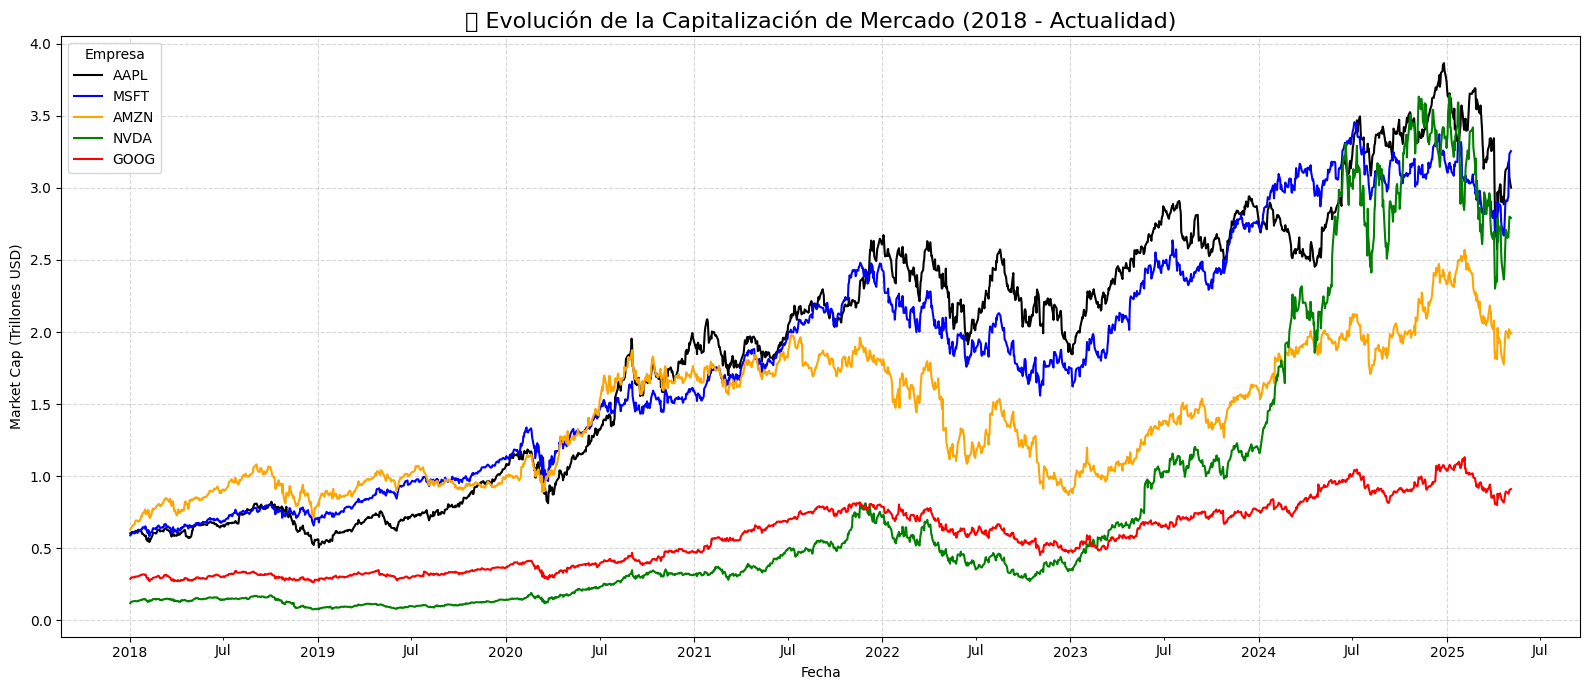

In [3]:
# Query SQL donde se realiza un JOIN entre la tabla precios_historicos y la tabla indicadores_fundamentales.
def get_market_cap_df():
    query = """
    SELECT
        ph.ticker,
        ph.date,
        ph.close,
        f.acciones_circulacion,
        ph.close * f.acciones_circulacion AS market_cap
    FROM
        precios_historicos ph
    LEFT JOIN
        indicadores_fundamentales f
        ON ph.ticker = f.ticker
    WHERE
        ph.ticker IN ('AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOG');
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df
# ✅ Paso 1: Obtener los datos desde PostgreSQL
df_market_cap = get_market_cap_df()  # Usamos la función con SQL LEFT JOIN

# ✅ Paso 2: Asegurar formato de fecha y tipos numéricos
df_market_cap['date'] = pd.to_datetime(df_market_cap['date'])
df_market_cap['market_cap'] = df_market_cap['market_cap'].astype(float)

# ✅ Paso 3: Filtrar por fecha desde 2018 y ordenar por ticker y fecha
df_filtrado = df_market_cap[df_market_cap['date'] >= '2018-01-01'].copy()
df_filtrado = df_filtrado.sort_values(by=['ticker', 'date'])

# ✅ Paso 4: Graficar evolución del Market Cap
tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOG']
colores = {
    'AAPL': 'black',
    'MSFT': 'blue',
    'AMZN': 'orange',
    'NVDA': 'green',
    'GOOG': 'red'
}

plt.style.use("default")
sns.set_palette("colorblind")
plt.figure(figsize=(16, 7))

for ticker in tickers:
    datos = df_filtrado[df_filtrado['ticker'] == ticker]
    plt.plot(
        datos['date'],
        datos['market_cap'] / 1e12,
        label=ticker,
        color=colores[ticker],
        linewidth=1.5
    )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

plt.title('📈 Evolución de la Capitalización de Mercado (2018 - Actualidad)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Market Cap (Trillones USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Empresa", loc='upper left')
plt.tight_layout()
plt.show()


## 📈 Evolución de la Capitalización de Mercado (2018 - Actualidad)

Se presenta la evolución histórica de la capitalización bursátil de cinco gigantes tecnológicas: **Apple (AAPL)**, **Microsoft (MSFT)**, **Amazon (AMZN)**, **Nvidia (NVDA)** y **Alphabet/Google (GOOG)**, calculada como:

> `Market Cap = Precio de Cierre × Acciones en Circulación`

Los valores están expresados en **trillones de dólares (USD)**, con series temporales desde enero de 2018 hasta mayo de 2025.

---

### 🔍 Observaciones Clave

#### ⚫ Apple (AAPL)
- Crecimiento estable y continuo durante todo el período.
- Supera los **3T USD** desde 2022 y mantiene ese nivel con relativa estabilidad.
- Refleja una confianza constante del mercado en su modelo de negocio diversificado.

#### 🟦 Microsoft (MSFT)
- Similar a Apple, mantiene un crecimiento sostenido y consistente.
- También supera los **3T USD** en 2024, impulsado por su liderazgo en servicios en la nube y avances en IA empresarial.
- Muestra menos volatilidad relativa frente a sus pares.

#### 🟧 Amazon (AMZN)
- Alcanza su punto máximo en 2021 cerca de los **2T USD**, para luego experimentar una caída pronunciada en 2022.
- La recuperación a partir de 2023 es más gradual, reflejando sensibilidad a condiciones macroeconómicas.
- Las presiones inflacionarias y de logística impactaron su valuación post-pandemia.

#### 🟩 Nvidia (NVDA)
- Exhibe el comportamiento más explosivo del grupo.
- En menos de dos años (2023–2024) pasa de **~0.5T a más de 3.5T USD**.
- Su capitalización se dispara por el auge de la inteligencia artificial y la demanda global de GPUs.
- Es la acción más volátil en el gráfico.

#### 🟥 Google (GOOG)
- Evolución más contenida comparada con el resto.
- Se mantiene entre **0.3T y 1.5T USD** con incrementos graduales y moderados.
- Posiblemente afectada por la competencia publicitaria, restricciones regulatorias y menores expectativas de crecimiento.

---

### 📊 Tendencias Generales

- Se observan **picos en 2021**, una **corrección clara en 2022**, y una **recuperación entre 2023 y 2024**.
- La capitalización de las empresas refleja no solo fundamentos propios, sino también el impacto de **eventos macroeconómicos globales** (pandemia, inflación, subas de tasas).
- **Nvidia rompe el patrón** con un rally excepcional ligado directamente al auge de la IA.

---

### 🎯 Conclusión

Este análisis permite visualizar el **peso de cada empresa en el mercado**, identificar **cambios estructurales** y entender cómo diferentes factores impactan el valor percibido de las grandes tecnológicas.  
- **Apple y Microsoft** destacan por su estabilidad y liderazgo sostenido.  
- **Amazon y Google**, más sensibles a factores externos.  
- **Nvidia**, ejemplo claro de un nuevo ciclo de crecimiento acelerado impulsado por innovación tecnológica.



## 📊 01. 02 -  Análisis de la Distribución de Retornos Diarios (2018 - Actualidad)

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1670029726.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


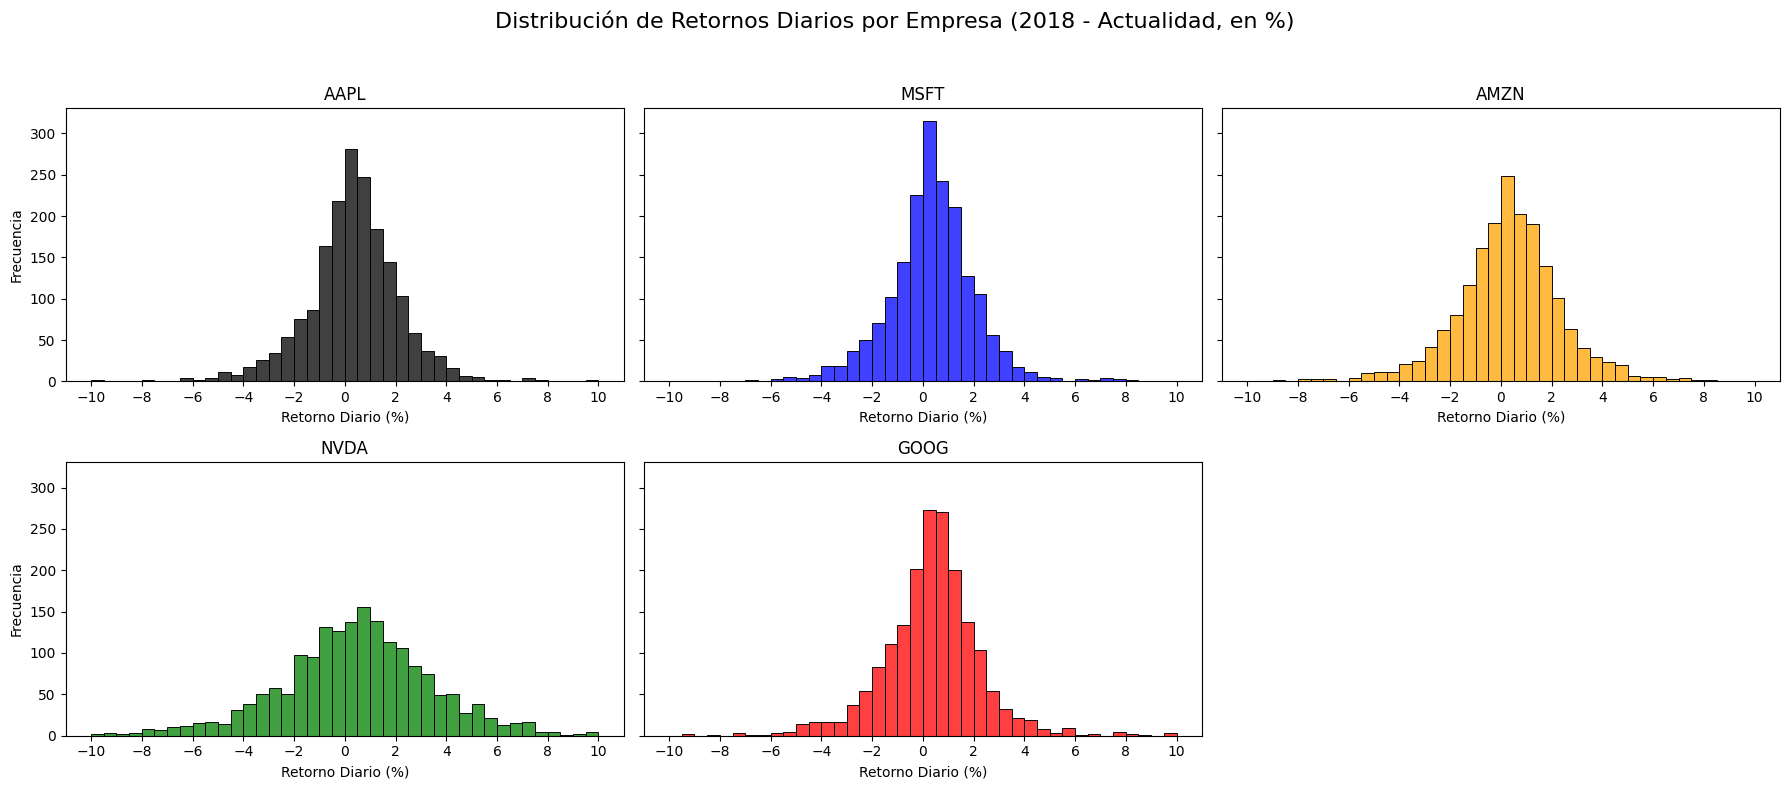

In [4]:
# funcion para obtener las variaciones diarias de precios en la base de datos
def get_variaciones_df():
    query = """
    SELECT ticker, date, var_daily
    FROM precios_variaciones
    WHERE ticker IN ('AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOG');
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Asegurar formato de fecha
    df['date'] = pd.to_datetime(df['date'])
    return df

variaciones_df = get_variaciones_df()

# Configuración
plt.style.use("default")
tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOG']
colores = {
    'AAPL': 'black',
    'MSFT': 'blue',
    'AMZN': 'orange',
    'NVDA': 'green',
    'GOOG': 'red'
}

# Filtrado y transformación de datos
variaciones_filtradas = variaciones_df[
    (variaciones_df['ticker'].isin(tickers)) &
    (variaciones_df['date'] >= '2018-01-01')
].copy()

# Retorno diario redondeado a 0.5% (en porcentaje)
variaciones_filtradas["var_daily_pct_rounded"] = (
    (variaciones_filtradas["var_daily"] * 100) / 0.5
).round() * 0.5

# Bins de -10% a +10% en intervalos de 0.5%
bins_pct = np.arange(-10, 10.5, 0.5)

# Crear figura y subplots 3x2
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=True)
axes = axes.flatten()

# Dibujar un histograma por ticker
for i, ticker in enumerate(tickers):
    datos = variaciones_filtradas[variaciones_filtradas["ticker"] == ticker]
    sns.histplot(
        data=datos,
        x="var_daily_pct_rounded",
        bins=bins_pct,
        color=colores[ticker],
        ax=axes[i]
    )
    axes[i].set_title(ticker)
    axes[i].set_xlabel("Retorno Diario (%)")
    axes[i].set_xticks(np.arange(-10, 11, 2))
    if i % 3 == 0:
        axes[i].set_ylabel("Frecuencia")
    else:
        axes[i].set_ylabel("")

# Eliminar el subplot vacío si hay menos de 6 empresas
if len(tickers) < len(axes):
    fig.delaxes(axes[-1])

# Título y layout final
plt.suptitle("Distribución de Retornos Diarios por Empresa (2018 - Actualidad, en %)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 📊 Análisis de la Distribución de Retornos Diarios (2018 - Actualidad)

Se graficaron los retornos diarios redondeados a 0.5% para las empresas **AAPL**, **MSFT**, **AMZN**, **NVDA** y **GOOG**, en escala de porcentaje y con bins consistentes. A continuación, se destacan las observaciones más relevantes por empresa:

---

### ⚫ Apple (AAPL)
- Presenta una **distribución simétrica y compacta**, centrada cerca del 0%.
- Poca frecuencia de eventos extremos.
- Confirma su comportamiento **estable y defensivo**.

---

### 🟦 Microsoft (MSFT)
- Perfil muy similar al de Apple: distribución concentrada y bajo riesgo.
- Leves colas hacia ±6%, pero rara vez ocurren.
- Refleja su estabilidad como empresa consolidada en el mercado.

---

### 🟧 Amazon (AMZN)
- Distribución levemente **más dispersa** que AAPL y MSFT.
- Colas más extendidas hacia +8% y -8%.
- Muestra algo más de volatilidad, especialmente en entornos macroeconómicos tensos (e.g. 2022).

---

### 🟩 Nvidia (NVDA)
- Claramente la **más volátil del grupo**.
- Retornos frecuentes entre ±5%, con eventos que superan ±8%.
- Curva **más achatada y ancha**, lo que indica dispersión alta.
- Alineado con su perfil de crecimiento agresivo y especulación ligada a la IA.

---

### 🟥 Alphabet (GOOG)
- Distribución intermedia: más ancha que MSFT/AAPL, pero más contenida que NVDA.
- Retornos fuera del centro algo más frecuentes (±4% a ±6%).
- Refleja su exposición tanto a ciclos tecnológicos como publicitarios.

---

## 🎯 Conclusiones Generales

- **AAPL y MSFT** → las más estables, ideales para perfiles conservadores.
- **NVDA** → mayor volatilidad y riesgo, pero con potencial de subas explosivas.
- **AMZN y GOOG** → intermedios en términos de dispersión.
- Esta información es clave para evaluar **riesgo asociado** a cada acción en contextos de inversión o trading.


## 01. 04 📊 Fundamentales

In [5]:
def get_fundamentales_df():
    query = """
    SELECT *
    FROM indicadores_fundamentales;
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    return df

fundamentales_df = get_fundamentales_df()

# Columnas a analizar
columnas_interes = [
    "per", "roe", "eps_growth_yoy",
    "deuda_patrimonio", "margen_neto",
    "dividend_yield", "market_cap"
]


# Verificar tipos de datos y estadísticas
fundamentales_df[columnas_interes].info(), fundamentales_df[columnas_interes].describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   per               479 non-null    float64
 1   roe               460 non-null    float64
 2   eps_growth_yoy    443 non-null    float64
 3   deuda_patrimonio  446 non-null    float64
 4   margen_neto       500 non-null    float64
 5   dividend_yield    409 non-null    float64
 6   market_cap        500 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 27.5 KB


C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\4185754229.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


(None,
                per         roe  eps_growth_yoy  deuda_patrimonio  margen_neto  \
 count   479.000000  460.000000      443.000000        446.000000   500.000000   
 mean     57.624155    0.324636        0.239666        143.898417     0.140514   
 std     398.529938    1.016825        1.420061        289.692608     0.143728   
 min       5.538043   -1.632120       -0.985000          0.110000    -1.056660   
 25%      16.518095    0.087973       -0.145000         37.539250     0.070088   
 50%      23.926155    0.159595        0.048000         73.757500     0.129480   
 75%      34.727581    0.302032        0.237000        145.149500     0.201377   
 max    8382.500000   16.057690       15.891000       3091.238000     0.765870   
 
        dividend_yield    market_cap  
 count      409.000000  5.000000e+02  
 mean         2.429731  1.059867e+11  
 std          1.628210  3.030120e+11  
 min          0.030000  5.912057e+09  
 25%          1.180000  1.906266e+10  
 50%          2.160

### 🧾Estado general de los datos
- Muestras: 500 empresas.

- Variables clave (float64):

    - Tienen algunos valores faltantes, especialmente:

    - EPS Growth YoY (57 faltantes)

    - Dividend Yield (91 faltantes)

    - ROE, Deuda/Patrimonio, PER también con algunos vacíos.

- Outliers extremos:

    - PER: máximo de 8252 (fuera de rango típico).

    - ROE: máximo 16.06, también sospechoso.

    - Deuda/Patrimonio: valores hasta 3091 → empresas ultraapalancadas.

    - EPS Growth YoY: hasta +15.9, lo cual puede sesgar histogramas.

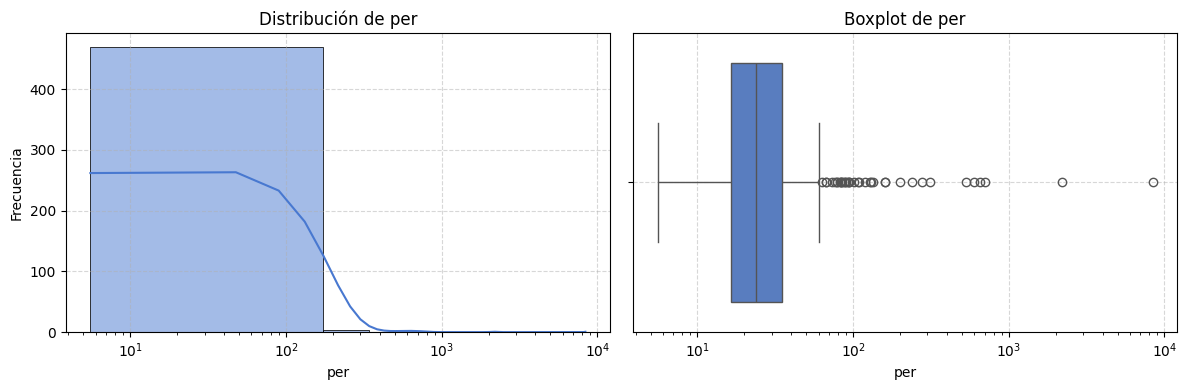

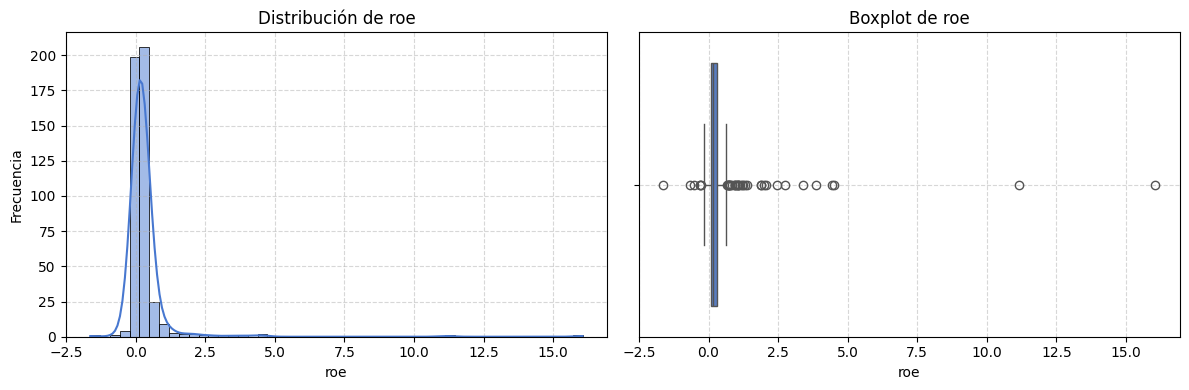

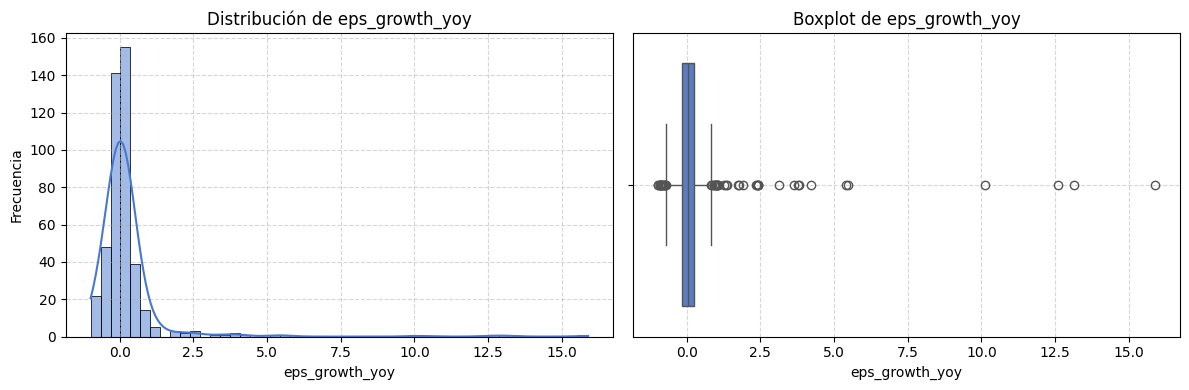

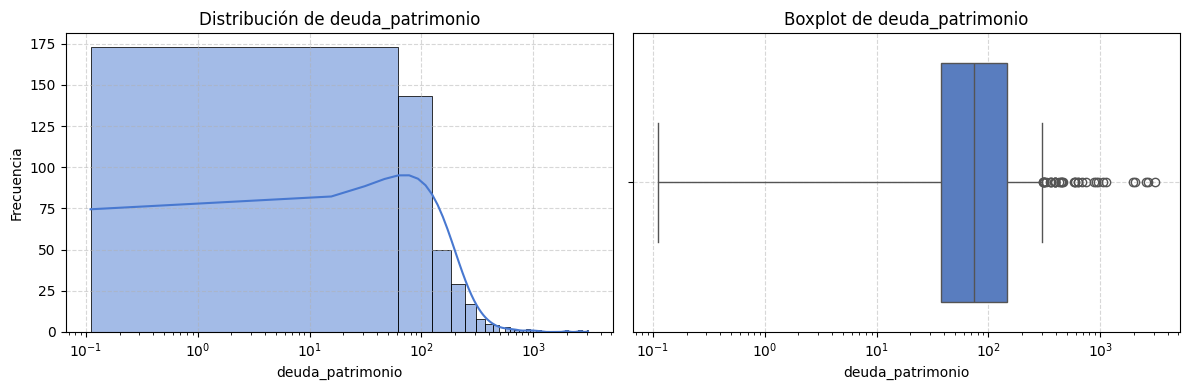

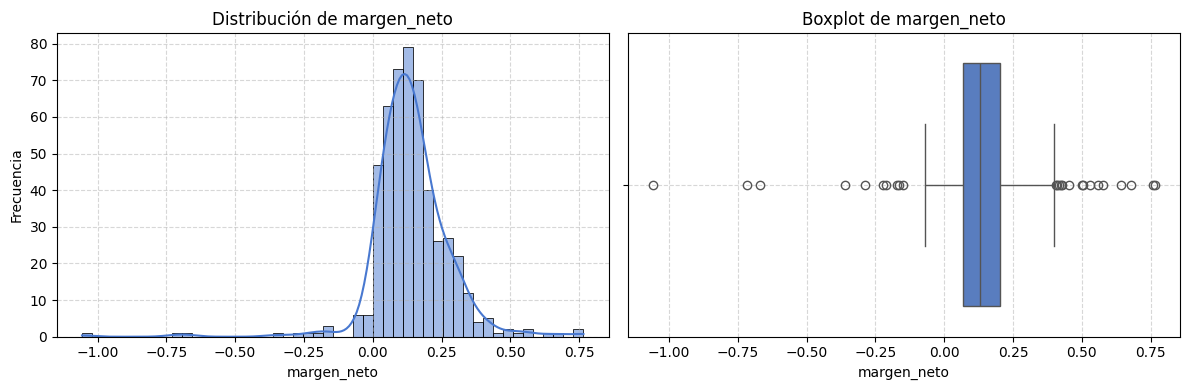

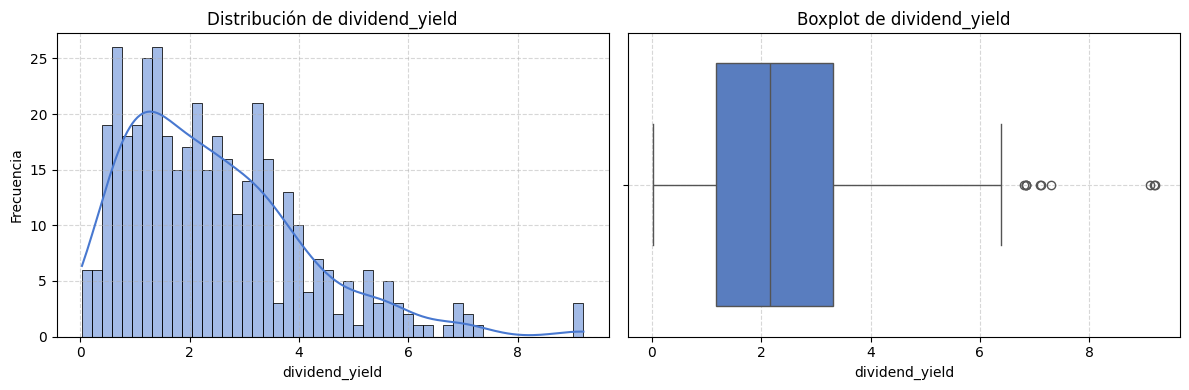

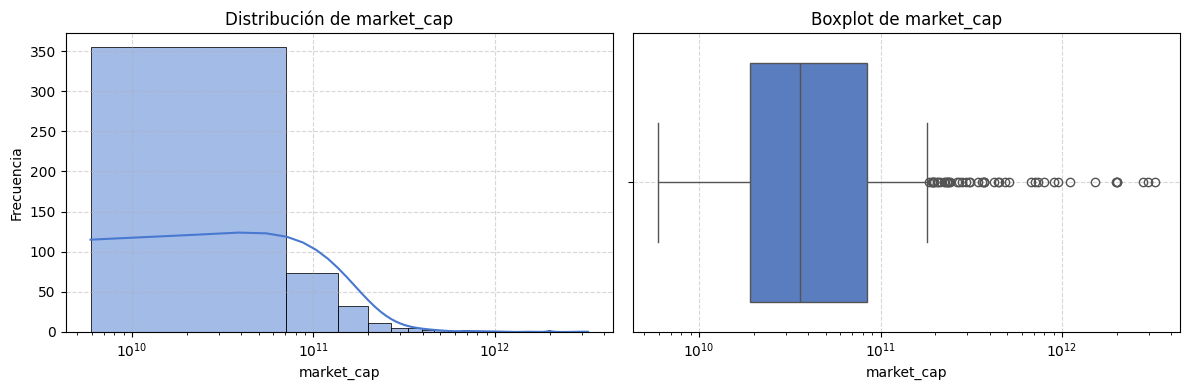

In [6]:

# Lista de indicadores a graficar
indicadores = [
    ("per", True),
    ("roe", False),
    ("eps_growth_yoy", False),
    ("deuda_patrimonio", True),
    ("margen_neto", False),
    ("dividend_yield", False),
    ("market_cap", True)
]

# Estilo general
plt.style.use("default")
sns.set_palette("muted")

# Crear gráficos
for indicador, usar_log in indicadores:
    data = fundamentales_df[indicador].dropna()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histograma
    sns.histplot(data, kde=True, ax=axes[0], bins=50)
    axes[0].set_title(f"Distribución de {indicador}")
    if usar_log:
        axes[0].set_xscale("log")
    axes[0].set_xlabel(indicador)
    axes[0].set_ylabel("Frecuencia")
    axes[0].grid(True, linestyle="--", alpha=0.5)

    # Boxplot
    sns.boxplot(x=data, ax=axes[1])
    axes[1].set_title(f"Boxplot de {indicador}")
    if usar_log:
        axes[1].set_xscale("log")
    axes[1].set_xlabel(indicador)
    axes[1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()



## 📊 Análisis Univariado de Indicadores Fundamentales

Se analizaron 6 indicadores fundamentales clave para evaluar la salud financiera y la valoración relativa de las empresas del dataset. A continuación, se resumen las observaciones más relevantes de cada métrica:

---

### 💰 PER (Price to Earnings Ratio)
##### Cuántas veces los inversores están pagando por las ganancias de la empresa.     | Precio de la acción ÷ Ganancias por acción.
- Distribución extremadamente **sesgada a la derecha**, con algunos valores fuera de escala (>1000).
- La mayoría de las empresas tienen un PER razonable (entre 10 y 50).
- Outliers extremos pueden deberse a ingresos muy bajos o pérdidas momentáneas.
- **Escala logarítmica** fue necesaria para visualizarlo correctamente.

---

### 📈 ROE (Return on Equity)
#### Cuánto beneficio genera la empresa por cada unidad de capital.                 | Utilidad Neta ÷ Patrimonio Neto.
- La mayoría de los valores se agrupan entre 0% y 1%, pero hay valores atípicos hasta 16x.
- **Distribución asimétrica positiva**.
- Muchos valores cercanos a cero o negativos, lo cual podría indicar empresas no rentables o muy apalancadas.
- Fuertes outliers que deben analizarse con más contexto.

---

### 📊 EPS Growth YoY (Crecimiento del Beneficio por Acción Anual)
####  Qué tanto crecieron las ganancias por acción en el último año.                 | (EPS actual − EPS año anterior) ÷ EPS año anterior.
- Gran concentración cercana a 0, pero con valores que van hasta 15x.
- Muchas empresas con **crecimiento negativo o muy bajo**.
- Algunos outliers marcan crecimientos excepcionales.
- Métrica volátil que requiere limpieza si se usa para modelado.

---

### 🏦 Deuda / Patrimonio
####  Nivel de endeudamiento de la empresa.                                          | Total Deuda ÷ Patrimonio Neto.      
- Muy dispersa, **con casos extremos de apalancamiento** (hasta 3000%).
- Alta frecuencia de valores moderados (10–100), pero fuerte cola a la derecha.
- Escala logarítmica utilizada para evitar distorsión.
- Empresas muy endeudadas pueden estar en sectores capital-intensivos o en dificultades financieras.

---

### 📉 Margen Neto
#### Porcentaje de cada dólar de ventas que se convierte en ganancia.               | Utilidad Neta ÷ Ventas Totales.
- Distribución centrada cerca de 0.15 (15%) con **simetría razonable**.
- Algunos márgenes negativos significativos (< -50%), indicando pérdidas.
- Margen estable en la mayoría, pero con outliers tanto positivos como negativos.
- Útil para evaluar eficiencia operativa relativa.

---

### 💵 Dividend Yield
####  Rendimiento del dividendo respecto al precio de la acción.                     | Dividendo Anual ÷ Precio de la Acción.      
- La mayoría de las empresas ofrecen entre **0% y 5% de dividendos**.
- Distribución sesgada a la derecha.
- Algunos casos de yields extremos (>8%) podrían reflejar caídas en precio o situaciones especiales.
- Boxplot muestra una mediana entre 2% y 3%.

---

## 🧩 Conclusiones Generales

- Las métricas más **volátiles y propensas a outliers** son PER, EPS Growth y Deuda/Patrimonio.
- **Dividend Yield y Margen Neto** muestran mayor estabilidad y menor dispersión.
- El uso de escalas logarítmicas es esencial para representar indicadores como PER y Deuda/Patrimonio.
- Estos insights son útiles para:
  - Filtrado inicial de empresas para inversión.
  - Segmentación según perfil financiero.
  - Preparación de features para modelos predictivos.



C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\4185754229.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\2459435100.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conteo_caps.index, y=conteo_caps.values, palette="viridis")


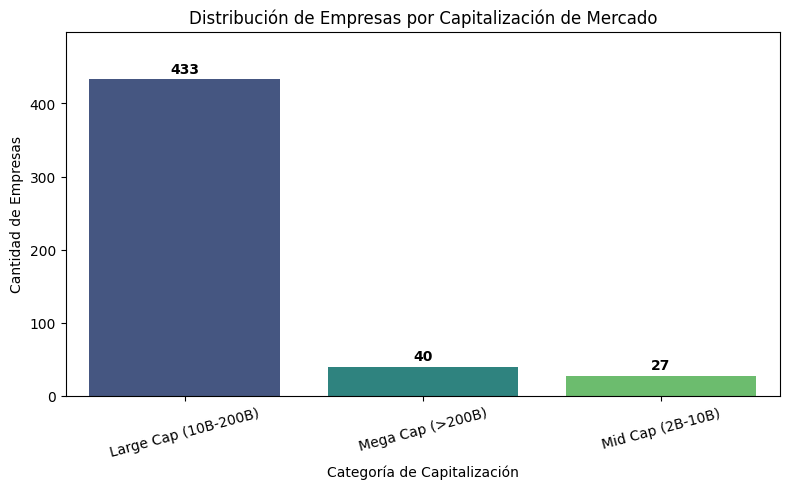

In [7]:
# Cargar archivo nuevamente
fundamentales_df = get_fundamentales_df()

# Convertir Market Cap de millones a miles de millones
fundamentales_df["Market Cap (B)"] = fundamentales_df["market_cap"] / 1e9  # NO 1e3

# Clasificar empresas según capitalización de mercado (en miles de millones)
def clasificar_market_cap(valor):
    if valor < 2:
        return "Small Cap (<2B)"
    elif 2 <= valor < 10:
        return "Mid Cap (2B-10B)"
    elif 10 <= valor < 200:
        return "Large Cap (10B-200B)"
    else:
        return "Mega Cap (>200B)"
    
fundamentales_df["Cap Group"] = fundamentales_df["Market Cap (B)"].apply(clasificar_market_cap)

# Contar empresas por categoría
conteo_caps = fundamentales_df["Cap Group"].value_counts().sort_index()

# Gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=conteo_caps.index, y=conteo_caps.values, palette="viridis")

# Agregar etiquetas arriba de cada barra
for i, value in enumerate(conteo_caps.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Estética
plt.title("Distribución de Empresas por Capitalización de Mercado")
plt.ylabel("Cantidad de Empresas")
plt.xlabel("Categoría de Capitalización")
plt.xticks(rotation=15)


# Eliminar límites automáticos si querés que se ajuste al contenido
plt.ylim(0, max(conteo_caps.values) * 1.15)  # Deja un poco de espacio arriba para las etiquetas

plt.tight_layout()
plt.show()



## 📊 Análisis: Distribución de Empresas por Capitalización de Mercado

Este gráfico representa la cantidad de empresas clasificadas por su capitalización bursátil (Market Cap) en billones de dólares estadounidenses (USD). Las categorías están definidas según rangos de tamaño de mercado ampliamente aceptados.

---

### 📌 Categorías y Resultados

| Categoría              | Rango de Capitalización   | Nº de Empresas |
|------------------------|----------------------------|----------------|
| **Large Cap**          | 10B–200B USD               | **433**        |
| **Mega Cap**           | >200B USD                  | **40**         |
| **Mid Cap**            | 2B–10B USD                 | **27**         |
| **Small Cap**          | <2B USD                    | *No representada* |

---

### 🔍 Observaciones Relevantes

- La mayoría de las empresas (**~87%**) se concentran en la categoría **Large Cap**, lo que indica un universo corporativo dominado por compañías consolidadas y de gran escala.
- Solo **40 empresas** superan los 200 mil millones USD en capitalización, calificando como **Mega Cap**, un grupo altamente selecto.
- Las **Mid Cap** representan una pequeña fracción del conjunto, con **27 empresas** entre 2 y 10 mil millones USD.
- La **ausencia de Small Caps** sugiere que:
  - están fuera del universo de estudio ya que se trata de las 500 empresas mas grande.

---

### 🧠 Interpretación

Esta distribución sugiere un enfoque analítico o inversor orientado hacia empresas **grandes, estables y consolidadas**, con menor exposición a firmas de menor capitalización que suelen tener mayor volatilidad, pero también más potencial de crecimiento.

---

### 🎯 Conclusión

El panorama revela un sesgo hacia empresas de gran tamaño, lo que puede beneficiar análisis enfocados en estabilidad, poder de mercado y liderazgo sectorial, pero limita la visión de oportunidades emergentes en los tramos más bajos del espectro de capitalización.


## ⚙️ 01.05 Análisis del Resumen de Inversión

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\2993224227.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\2993224227.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=decision_counts.index, y=decision_counts.values, palette=colores_barras)


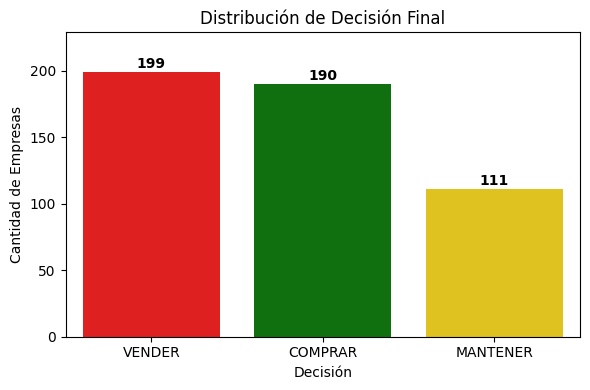

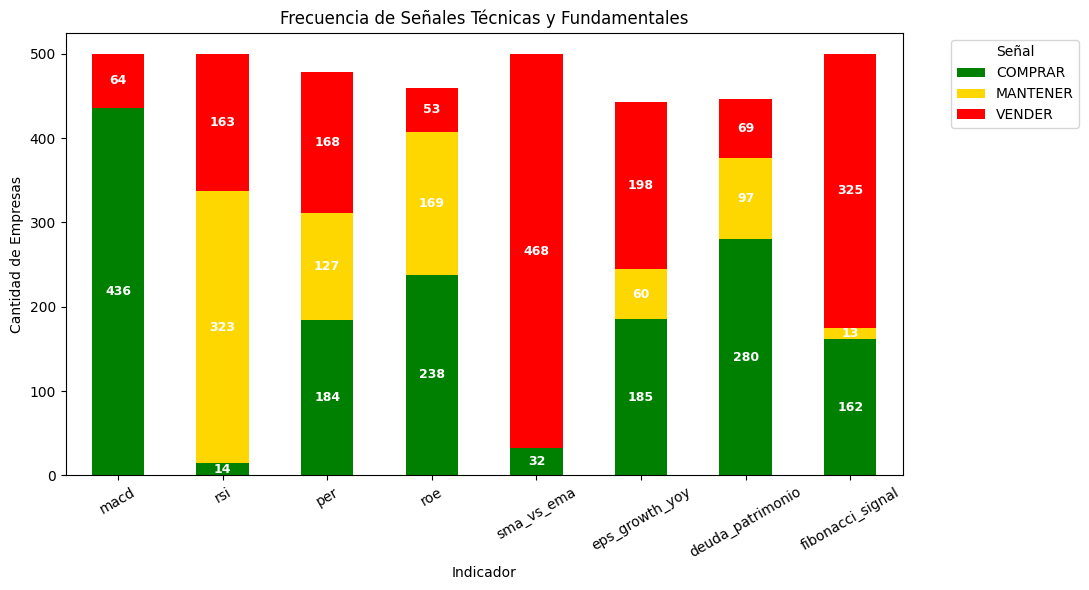

In [8]:
def get_resumen_inversion_df():
    query = """
    SELECT *
    FROM resumen_inversion;
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    return df

resumen_inversion_df = get_resumen_inversion_df()

# 1. Distribución de la Decisión Final
decision_counts = resumen_inversion_df["decision_final"].value_counts()

# Colores personalizados por decisión
colores = {
    "COMPRAR": "green",
    "VENDER": "red",
    "MANTENER": "gold"
}

# Obtener los colores en el orden correcto
colores_barras = [colores.get(decision, "gray") for decision in decision_counts.index]

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=decision_counts.index, y=decision_counts.values, palette=colores_barras)

# Agregar etiquetas de cantidad arriba de cada barra
for i, value in enumerate(decision_counts.values):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Estética
plt.title("Distribución de Decisión Final")
plt.ylabel("Cantidad de Empresas")
plt.xlabel("Decisión")
plt.ylim(0, max(decision_counts.values) * 1.15)  # Deja espacio arriba
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 2. Frecuencia de señales técnicas y fundamentales (incluye Fibonacci)
# -----------------------------------------------------

mapa_fibonacci = {
    "SOPORTE": "COMPRAR",
    "RESISTENCIA": "VENDER",
    "NEUTRO": "MANTENER"
}
resumen_inversion_df["fibonacci_signal"] = resumen_inversion_df["estado_fibonacci"].map(mapa_fibonacci)

columnas_senales = [
    "macd", "rsi", "per", "roe", "sma_vs_ema",
    "eps_growth_yoy", "deuda_patrimonio", "fibonacci_signal"
]

# Calcular conteos por valor de señal (COMPRAR, VENDER, MANTENER)
conteos = resumen_inversion_df[columnas_senales].apply(lambda col: col.value_counts()).fillna(0)

# Asegurar orden de señales
conteos = conteos.reindex(['COMPRAR', 'MANTENER', 'VENDER'])

# Colores personalizados
colores = {
    'COMPRAR': 'green',
    'MANTENER': 'gold',
    'VENDER': 'red'
}

# Gráfico apilado con colores definidos
fig, ax = plt.subplots(figsize=(11, 6))
conteos.T.plot(kind='bar', stacked=True, ax=ax, color=[colores[s] for s in conteos.index])

# Agregar valores en cada barra apilada
for idx, indicador in enumerate(conteos.columns):
    base = 0
    for señal in conteos.index:
        valor = conteos.loc[señal, indicador]
        if valor > 0:
            ax.text(idx, base + valor / 2, int(valor), ha='center', va='center', color='white', fontsize=9, fontweight='bold')
            base += valor

# Estética
plt.title("Frecuencia de Señales Técnicas y Fundamentales")
plt.ylabel("Cantidad de Empresas")
plt.xlabel("Indicador")
plt.xticks(rotation=30)
plt.legend(title="Señal", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 📊 Análisis de Señales y Decisión Final

Este análisis se basa en dos gráficos fundamentales que exploran la distribución de recomendaciones de inversión (`COMPRAR`, `MANTENER`, `VENDER`) tanto desde un enfoque de decisión final consolidada como desde la frecuencia de señales individuales, técnicas y fundamentales.

---

### 📌 1. Distribución de la Decisión Final

| Decisión   | Empresas |
|------------|----------|
| **VENDER** | 199      |
| **COMPRAR**| 190      |
| **MANTENER**| 111     |

- Las decisiones de **VENDER** son las más frecuentes, aunque **COMPRAR** le sigue muy de cerca.
- **MANTENER** es la menos común, lo que refleja una tendencia del sistema a emitir señales más definidas (acción directa).
- La distribución sugiere un entorno de mercado donde predominan evaluaciones con posiciones claras, ya sea de oportunidad o precaución.

---

### 📊 2. Frecuencia de Señales Técnicas y Fundamentales

| Indicador            | COMPRAR | MANTENER | VENDER |
|----------------------|---------|----------|--------|
| **macd**             | 436     | -        | 64     |
| **rsi**              | 14      | 323      | 163    |
| **per**              | 184     | 127      | 168    |
| **roe**              | 238     | 169      | 53     |
| **sma_vs_ema**       | 32      | -        | 468    |
| **eps_growth_yoy**   | 185     | 60       | 198    |
| **deuda_patrimonio** | 280     | 97       | 69     |
| **fibonacci_signal** | 162     | 13       | 325    |

#### 🧠 Observaciones:
- **MACD** emite una señal fuertemente positiva con 436 recomendaciones de compra.
- **SMA vs EMA** y **fibonacci_signal** son las fuentes más agresivas de señales de venta (468 y 325 respectivamente).
- **RSI** se destaca por generar muchas señales de **mantener** (323), indicando indecisión o zona neutral.
- **PER** y **ROE** están más equilibrados, lo cual puede reflejar un análisis fundamental mixto o dependiente del sector.

---

### 🎯 Conclusión

- El sistema tiende a generar decisiones definidas, con una ligera inclinación hacia la venta.
- Las señales técnicas como **MACD** y **SMA/EMA** tienden a ser dominantes y extremas (muy positivas o muy negativas).
- Las fundamentales aportan mayor diversidad: algunas como **deuda/patrimonio** favorecen compra, mientras que **PER** y **EPS** están más distribuidas.
- Esta combinación sugiere un enfoque robusto pero sensible a momentos de mercado extremos, ideal para escenarios de alta volatilidad.

---


# 02. Análisis Bivariado

## 🔁 02.01 Matriz de Correlación entre Indicadores Fundamentales

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\4185754229.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\3058815109.py:18: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Agus\Desktop\PFM\Proyecto-Final-Hack-io-limpio\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


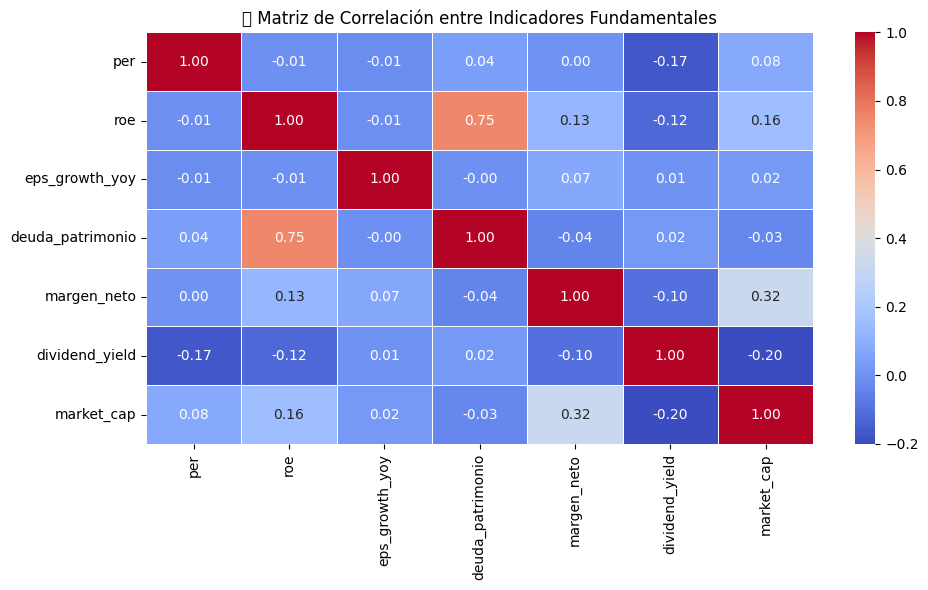

In [9]:
# Cargar archivo nuevamente
fundamentales_df = get_fundamentales_df()
# Columnas a analizar
fund_cols = [
    "per", "roe", "eps_growth_yoy",
    "deuda_patrimonio", "margen_neto",
    "dividend_yield", "market_cap"
]
# Limpiar datos
df_corr = fundamentales_df[fund_cols].dropna()

corr_matrix = df_corr.corr()

# Graficar
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔁 Matriz de Correlación entre Indicadores Fundamentales")
plt.tight_layout()
plt.show()


## 🔗 Matriz de Correlación entre Indicadores Fundamentales

La matriz de correlación muestra la relación lineal entre diferentes indicadores financieros fundamentales utilizados para analizar empresas. Los valores van desde **-1 (correlación negativa perfecta)** hasta **+1 (correlación positiva perfecta)**. Las celdas se colorean según la intensidad de la relación.

---

### 📌 Correlaciones Destacadas

#### 📈 Correlaciones positivas fuertes:
- **ROE y deuda/patrimonio** → `0.75`  
  Indica que las empresas con mayor retorno sobre el capital tienden a estar más apalancadas (mayor deuda relativa). Esto puede ser típico en negocios que usan deuda como palanca de crecimiento.

- **margen_neto y market_cap** → `0.32`  
  Sugiere que empresas con márgenes de beneficio más altos tienden a tener mayor capitalización de mercado, lo cual es coherente con modelos de negocios eficientes y escalables.

#### 📉 Correlaciones negativas:
- **dividend_yield y market_cap** → `-0.20`  
  Indica que empresas más grandes tienden a tener rendimientos por dividendo más bajos. Esto puede deberse a una mayor retención de ganancias para reinversión.

- **dividend_yield y per** → `-0.17`  
  Empresas con altos dividendos tienden a tener un PER más bajo, lo que puede reflejar expectativas de menor crecimiento.

---

### 🔍 Correlaciones débiles o nulas

- **eps_growth_yoy** presenta correlaciones muy bajas con el resto de los indicadores, lo cual indica que el crecimiento de ganancias interanual es relativamente independiente de otras métricas tradicionales como PER, ROE o margen neto.
- **per**, **roe**, **margen_neto** y **deuda_patrimonio** muestran muy poca relación entre sí en la mayoría de los casos (valores cercanos a cero), lo que sugiere que cada uno captura distintos aspectos del desempeño financiero.

---

### 🧠 Interpretación General

- La mayoría de los indicadores están débilmente correlacionados entre sí, lo cual **es deseable en análisis multifactorial**, ya que indica que cada variable aporta información diferenciada.
- Las únicas relaciones sólidas (como ROE vs deuda/patrimonio) deben ser monitoreadas para evitar sobreponderar factores redundantes en modelos de scoring o toma de decisiones.

---

### 🎯 Conclusión

Esta matriz valida que los indicadores fundamentales seleccionados ofrecen una **visión diversificada del perfil financiero** de las empresas, lo que enriquece el análisis sin introducir multicolinealidad significativa.


## 🔁 02.02 Relación entre Indicadores Fundamentales

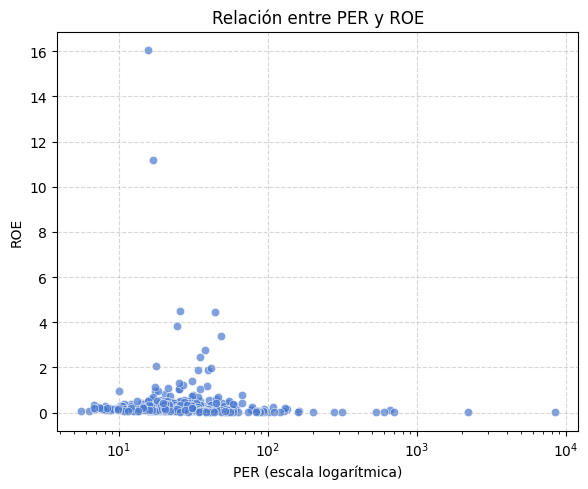

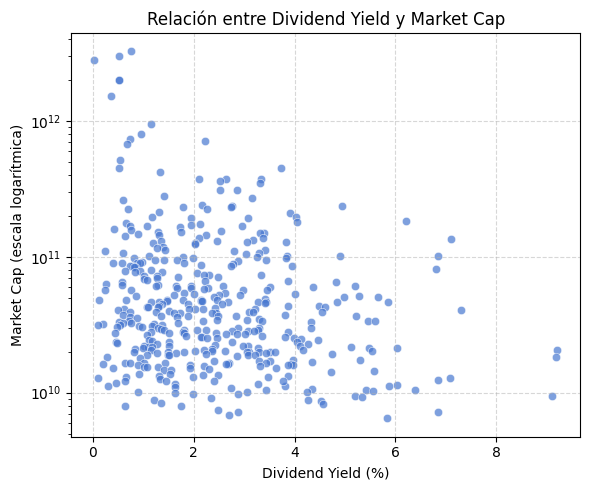

In [10]:
# Scatterplot: PER vs ROE
plt.figure(figsize=(6, 5))
sns.scatterplot(data=fundamentales_df, x="per", y="roe", alpha=0.7)
plt.xscale("log")
plt.title("Relación entre PER y ROE")
plt.xlabel("PER (escala logarítmica)")
plt.ylabel("ROE")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Scatterplot: Dividend Yield vs Market Cap
plt.figure(figsize=(6, 5))
sns.scatterplot(data=fundamentales_df, x="dividend_yield", y="market_cap", alpha=0.7)
plt.yscale("log")
plt.title("Relación entre Dividend Yield y Market Cap")
plt.xlabel("Dividend Yield (%)")
plt.ylabel("Market Cap (escala logarítmica)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## 🔁 Relación entre Indicadores Fundamentales

A continuación, se presentan dos gráficos de dispersión que analizan relaciones clave entre indicadores financieros comunes: **PER vs ROE** y **Dividend Yield vs Market Cap**. Ambos utilizan escalas logarítmicas para facilitar la visualización de amplios rangos de valores.

---

### 📊 Relación entre PER y ROE

- **Observación general**: La mayoría de los puntos se agrupan en la parte inferior izquierda del gráfico, con valores de PER menores a 100 y ROE entre 0 y 2.
- **Escala logarítmica**: Usada para PER, evidencia que la gran mayoría de empresas tienen PER bajos; los valores extremadamente altos son casos atípicos.
- **Outliers**: Se observan algunos casos con ROE elevados (>10) y PER intermedios, posiblemente empresas altamente rentables con valoraciones aún razonables.
- **Correlación baja**: El gráfico refuerza la correlación cercana a cero observada en la matriz de correlación anterior, lo que indica que **PER y ROE no presentan una relación lineal clara** en este conjunto de datos.

---

### 📉 Relación entre Dividend Yield y Market Cap

- **Distribución dispersa**: Las empresas con alta capitalización de mercado (≥10¹² USD) tienden a tener **rendimientos por dividendo más bajos** (1–2%), mientras que las de menor capitalización presentan mayor variabilidad.
- **Tendencia negativa suave**: Confirma la **correlación negativa leve (-0.20)** observada en la matriz de correlación: empresas más grandes suelen repartir menos dividendos en relación a su precio.
- **Casos extremos**: Hay empresas con dividend yields >6% y market cap inferiores a 10¹⁰, lo que puede indicar compañías en sectores maduros o con baja reinversión de utilidades.

---

### 🎯 Conclusión

- El análisis visual reafirma que **no todas las métricas fundamentales están correlacionadas de forma directa**, lo cual es útil para construir modelos de evaluación más completos y menos redundantes.
- **PER y ROE** muestran independencia, lo que sugiere que pueden usarse conjuntamente para identificar valoraciones anómalas o rentabilidades inusuales.
- **Market Cap y Dividend Yield** tienen una relación inversa leve, lo que sugiere una estrategia de dividendos más conservadora en compañías grandes.

Estas visualizaciones ayudan a **identificar patrones, outliers y validar relaciones** numéricas mediante análisis visual complementario.


## 📊 02.03 Distribución de Indicadores Fundamentales por Sector

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\3751521474.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


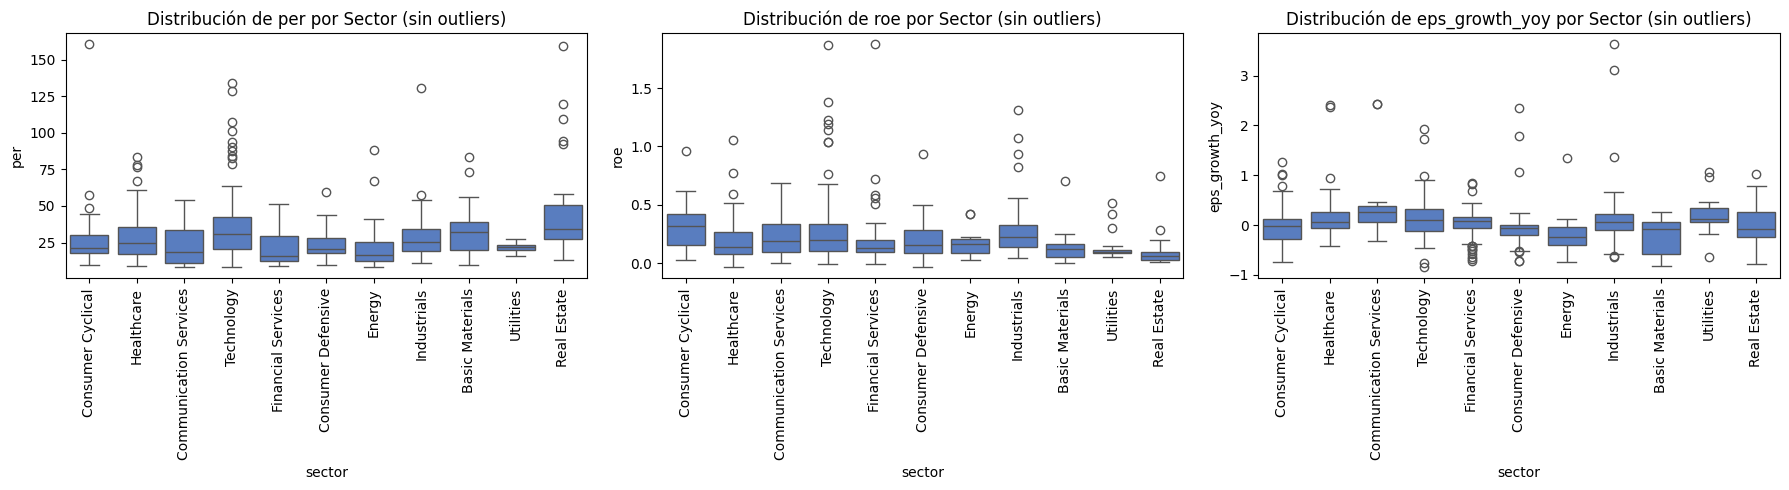

In [11]:
def get_fundamentales_sector_df():
    query = """
    SELECT
        f.ticker AS ticker,
        f.per,
        f.roe,
        f.eps_growth_yoy,
        f.deuda_patrimonio,
        f.margen_neto,
        f.dividend_yield,
        f.market_cap,
        f.ranking_marketcap,
        f.acciones_circulacion,
        e.sector,
        e.industry
FROM
    indicadores_fundamentales f
LEFT JOIN
    empresas e ON f.ticker = e.ticker;
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

fundamentales_sector = get_fundamentales_sector_df()

# Función para limitar outliers por columna
def limitar_outliers(fundamentales_sector, columna, condicion=True):
    q_low = fundamentales_sector[columna].quantile(0.02)
    q_high = fundamentales_sector[columna].quantile(0.98)
    if condicion == True:
        return fundamentales_sector[(fundamentales_sector[columna] >= q_low) & (fundamentales_sector[columna] <= q_high)]
    else:
        return fundamentales_sector[(fundamentales_sector[columna] <= q_low) | (fundamentales_sector[columna] >= q_high)]
    
# Aplicar filtro y graficar
variables = ["per", "roe", "eps_growth_yoy"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# analizamos sin los outliers
for i, var in enumerate(variables):
    df_filtrado = limitar_outliers(fundamentales_sector, var, True)
    sns.boxplot(
        data=df_filtrado,
        x="sector",
        y=var,
        ax=axes[i]
    )
    axes[i].set_title(f"Distribución de {var} por Sector (sin outliers)")
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


## 📊 Análisis Sectorial de Indicadores Fundamentales (sin outliers)

Los gráficos muestran la distribución de tres indicadores clave —**PER**, **ROE** y **EPS Growth YoY**— para diferentes sectores económicos. Se han eliminado los valores atípicos (2% inferior y superior) para facilitar una comparación visual más clara y justa entre sectores.

---

### 📈 1. PER por Sector

- **Media y dispersión**: La mayoría de los sectores muestran rangos de PER similares (entre 10 y 40), aunque algunos como **Real Estate**, **Technology** y **Healthcare** presentan colas largas hacia valores más altos.
- **Outliers extremos**: Pese al filtro, aún se destacan algunos valores superiores a 100, lo que podría reflejar empresas con beneficios bajos (denominador pequeño) o altas expectativas de crecimiento.
- **Sectores con PER más bajos**: Utilities y Basic Materials tienden a tener valoraciones más conservadoras.

---

### 📉 2. ROE por Sector

- **Mediana baja en general**: La mayoría de los sectores presenta valores medianos de ROE por debajo del 0.2, lo que indica una rentabilidad moderada sobre el capital.
- **Tecnología y Healthcare**: Muestran una distribución más extendida hacia valores altos de ROE, lo que puede indicar modelos de negocio más rentables.
- **Real Estate y Utilities**: Tienen las distribuciones más bajas y estrechas de ROE, reflejando márgenes más ajustados o estructuras de capital intensivas.

---

### 📈 3. EPS Growth YoY por Sector

- **Mayor dispersión**: Este indicador presenta la mayor variabilidad entre sectores.
- **Technology e Industrials**: Exponen colas largas hacia valores de crecimiento muy altos (>200%), lo que puede reflejar disrupción tecnológica o ciclos industriales positivos.
- **Financial Services**: Muestra varios valores negativos, lo que puede indicar caídas recientes en beneficios anuales (volatilidad propia del sector).
- **Healthcare y Consumer Defensive**: Tienen crecimientos más estables y centrados.

---

### 🎯 Conclusión

- El análisis evidencia que **el comportamiento de los indicadores fundamentales varía significativamente por sector**.
- Sectores como **Technology** y **Healthcare** tienden a mostrar mayor rentabilidad (ROE) y potencial de crecimiento (EPS Growth), pero también mayor dispersión.
- Sectores como **Utilities**, **Real Estate** y **Consumer Defensive** reflejan comportamientos más conservadores, ideales para estrategias defensivas.
- La eliminación de outliers permite detectar **tendencias centrales más representativas** y facilita una comparación homogénea entre sectores.

Este enfoque es ideal para construir estrategias de selección sectorial basadas en fundamentos objetivos.


### Analizamos los outliers

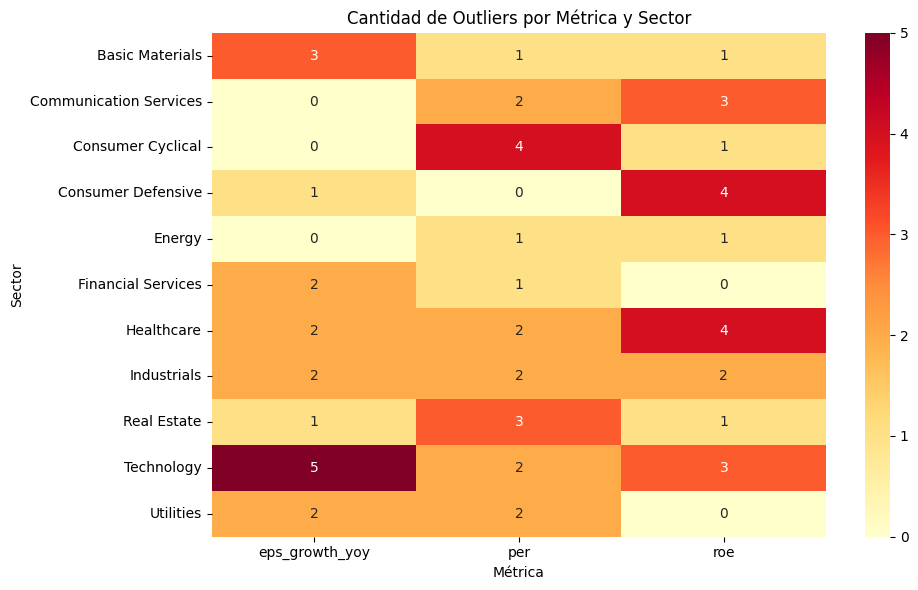

In [12]:
# 1. Detectar outliers por métrica y marcarlo
variables = ["per", "roe", "eps_growth_yoy"]
outlier_flags = []

for var in variables:
    q_low = fundamentales_sector[var].quantile(0.02)
    q_high = fundamentales_sector[var].quantile(0.98)

    df_out = fundamentales_sector[
        (fundamentales_sector[var] < q_low) | (fundamentales_sector[var] > q_high)
    ][["ticker", "sector"]].copy()

    df_out["métrica"] = var
    outlier_flags.append(df_out)

# 2. Unir todos los outliers detectados
outliers_df = pd.concat(outlier_flags, ignore_index=True)

# 3. Agrupar: cantidad de outliers por sector y métrica
conteo_sector_metrica = outliers_df.groupby(["métrica", "sector"]).size().reset_index(name="cantidad")

# 4. Gráfico de calor sector vs métrica
pivot = conteo_sector_metrica.pivot(index="sector", columns="métrica", values="cantidad").fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="YlOrRd", fmt=".0f")
plt.title("Cantidad de Outliers por Métrica y Sector")
plt.xlabel("Métrica")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()

## 🔍 Mapa de Calor: Outliers por Métrica y Sector

Este heatmap representa la cantidad de empresas **outliers** por **sector** y **métrica fundamental**:

- `eps_growth_yoy`: crecimiento de ganancias anual.
- `per`: Price to Earnings Ratio (valoración).
- `roe`: retorno sobre el patrimonio.

Se consideraron como outliers aquellos valores que se encuentran fuera del rango percentil 2%-98% para cada métrica.

---

### 📊 Observaciones Clave

#### 📈 `eps_growth_yoy`
- **Technology** lidera con 5 empresas outliers, lo que evidencia su alta **volatilidad en crecimiento**.
- **Healthcare**, **Industrials**, y **Utilities** también muestran empresas con variaciones extremas de ganancias.
- **Energy** y **Consumer Cyclical** no presentan outliers aquí, reflejando mayor estabilidad en esta métrica dentro del rango analizado.

#### 💰 `per` (Price to Earnings Ratio)
- **Consumer Cyclical** tiene la mayor cantidad de outliers en valoración (PER), con 4 empresas. Esto sugiere que el mercado valora algunas compañías de este sector de forma muy distinta al promedio.
- **Real Estate** y **Communication Services** también muestran empresas con PER fuera de los rangos normales, indicando posibles **desalineaciones precio/ganancia**.

#### 🏦 `roe` (Return on Equity)
- **Healthcare** y **Consumer Defensive** lideran con 4 outliers cada uno, indicando una gran dispersión en la rentabilidad sobre capital.
- **Communication Services** y **Technology** también muestran casos con rentabilidades extremas, tanto positivas como negativas.
- **Utilities** y **Financial Services** no presentan outliers en ROE, indicando **rentabilidades más estables** o cercanas al promedio.

---

### 🎯 Conclusión

- El sector **Technology** es el único con alta presencia de outliers en **todas las métricas**, destacando su carácter disruptivo y riesgoso.
- **Consumer Cyclical** y **Healthcare** también muestran comportamientos extremos, pero en métricas más específicas (PER y ROE respectivamente).
- Sectores como **Energy**, **Utilities** y **Financial Services** presentan comportamientos más moderados o consistentes.

Este análisis permite focalizar la atención en **sectores con alta dispersión fundamental**, lo que puede implicar tanto **riesgos** como **oportunidades** dependiendo del contexto de mercado y estrategia de inversión.


## 📊 02.04 Promedio de Retorno Anual por Sector

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1383249404.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1383249404.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


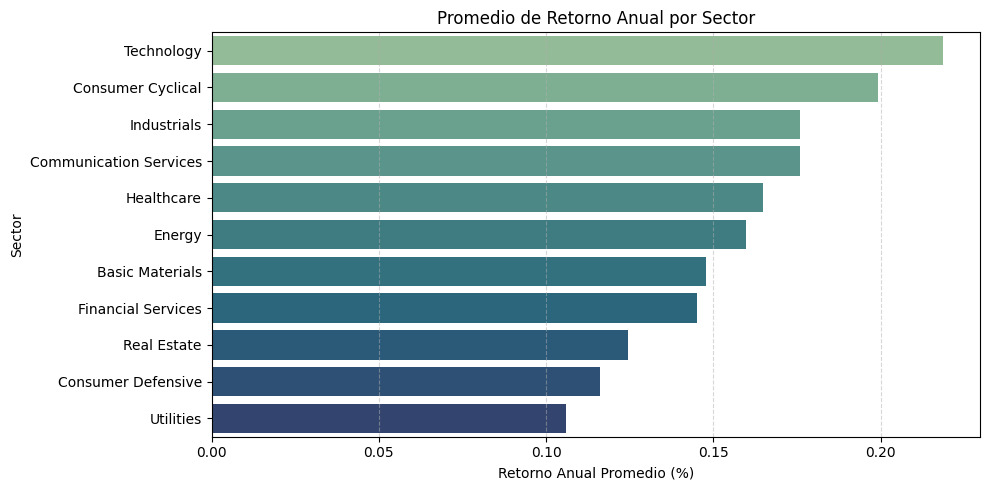

In [13]:
def get_promedios_var_annual_por_sector():
    query = """
    SELECT
        e.sector,
        AVG(pv.var_annual::FLOAT) AS promedio_var_annual
    FROM
        precios_variaciones pv
    JOIN
        empresas e ON pv.ticker = e.ticker
    WHERE
        pv.var_annual IS NOT NULL
        AND pv.var_annual != 'NaN' -- <== EXCLUYE strings tipo 'NaN'
        AND pv.date >= '2008-01-03'
        AND e.sector IS NOT NULL
    GROUP BY
        e.sector
    ORDER BY
        promedio_var_annual DESC;
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Ejecutar la función
promedios_sector = get_promedios_var_annual_por_sector()
promedios_sector

# Graficar correctamente
plt.figure(figsize=(10, 5))
sns.barplot(
    data=promedios_sector,
    x="promedio_var_annual",
    y="sector",
    palette="crest"
)
plt.title("Promedio de Retorno Anual por Sector")
plt.xlabel("Retorno Anual Promedio (%)")
plt.ylabel("Sector")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



## 📊 Promedio de Retorno Anual por Sector

Este gráfico muestra el **retorno promedio anual** de las acciones, agrupadas por sector, desde el año **2008 en adelante**. El retorno anual (`var_annual`) se calculó como la variación porcentual del precio de cada acción en un año, y luego se promedió para cada sector.

---

### 🔝 Sectores con Mejor Desempeño

- **Technology** lidera con un retorno promedio superior al **21% anual**, destacándose como el sector más rentable. Esto refleja el crecimiento explosivo de empresas tecnológicas durante la última década, impulsado por la innovación digital, inteligencia artificial y servicios en la nube.
- **Consumer Cyclical** también se posiciona alto (casi **20%**), lo cual sugiere que empresas de consumo discrecional han sabido capitalizar el crecimiento post-crisis y las tendencias del consumidor.
- **Industrials** y **Communication Services** mantienen retornos sólidos, por encima del **16%**, lo cual puede atribuirse al repunte económico tras años de inversión en infraestructura y digitalización.

---

### 🔻 Sectores con Menor Desempeño

- **Utilities** y **Consumer Defensive** muestran los retornos más bajos, apenas superando el **10% anual**. Esto es esperable ya que son sectores considerados más estables y defensivos, menos propensos a grandes crecimientos, pero con menor volatilidad.
- **Real Estate** y **Financial Services** se encuentran en la parte media-baja del ranking, posiblemente afectados por tasas de interés y ciclos económicos.

---

### 🧠 Conclusión

- Los sectores **tecnológicos y cíclicos** han ofrecido los mayores retornos para inversores de largo plazo.
- Los sectores **defensivos y regulados** ofrecen menor rendimiento, pero potencialmente menos riesgo.
- Este análisis puede guiar decisiones de **asignación sectorial** en estrategias de inversión basadas en rendimiento histórico.



## 📉02.05 Relación entre RSI y Volatilidad (20 días)

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\2823118351.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


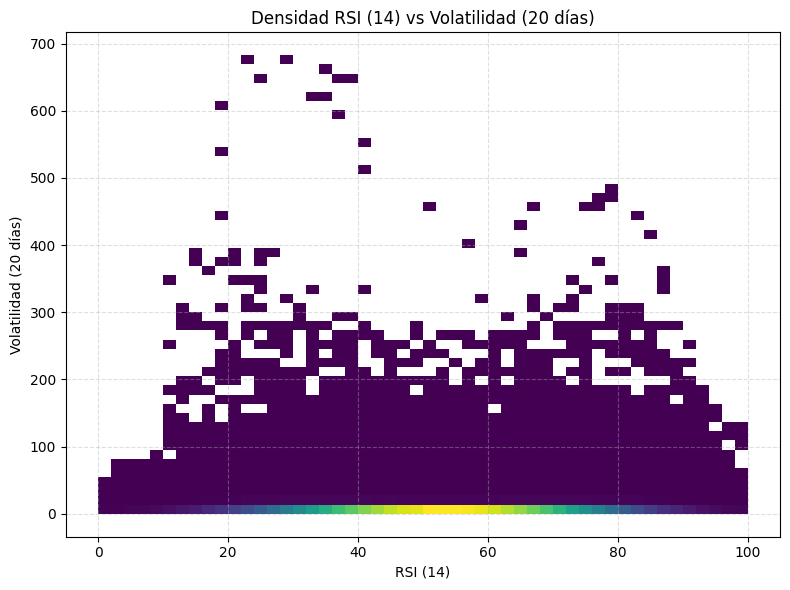

In [14]:
def get_indicadores_tecnicos_filtrados():
    query = """
    SELECT
        ticker,
        rsi_14,
        volatility_20
    FROM
        indicadores_tecnicos
    WHERE
        rsi_14 IS NOT NULL
        AND volatility_20 IS NOT NULL;
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df


# Cargar datos
tecnicos_filtrado = get_indicadores_tecnicos_filtrados()

# Crear heatmap de densidad
plt.figure(figsize=(8, 6))
sns.histplot(
    data=tecnicos_filtrado,
    x="rsi_14",
    y="volatility_20",
    bins=50,
    pmax=0.95,
    cmap="viridis"
)
plt.title("Densidad RSI (14) vs Volatilidad (20 días)")
plt.xlabel("RSI (14)")
plt.ylabel("Volatilidad (20 días)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## 📊 Densidad de RSI (14) vs Volatilidad (20 días)

El gráfico muestra un **heatmap de densidad** que permite visualizar la relación entre el **Índice de Fuerza Relativa (RSI)** y la **volatilidad de 20 días** para una gran cantidad de empresas. Esta visualización sustituye el clásico gráfico de dispersión cuando el volumen de datos es muy alto.

---

### 🔍 Observaciones Clave

- La mayoría de las observaciones se concentran en la franja de **RSI entre 40 y 70**, lo cual refleja una zona neutral o moderadamente sobrecomprada.
- **La volatilidad más común** se encuentra en valores bajos (aproximadamente entre **0 y 20**), como indica la mayor intensidad de color en esa región.
- No se detectan patrones evidentes de que RSI influya directamente sobre la volatilidad. Las zonas de **RSI muy bajos (0–20)** y **muy altos (80–100)** no muestran una volatilidad especialmente elevada.
- Algunos **valores extremos de volatilidad** (>500) aparecen con menor frecuencia, sin una correlación clara con el RSI.

---

### 📌 Conclusión

Aunque existe una amplia dispersión de valores, la densidad sugiere que:

- **La volatilidad tiende a ser baja** en la mayoría de los casos, sin importar el nivel de RSI.
- No hay una **relación directa** o simple entre RSI y volatilidad.
- Este análisis es útil para descartar la hipótesis de que niveles extremos de RSI se asocian necesariamente con mayor volatilidad.

Este enfoque permite visualizar grandes volúmenes de datos de forma más clara y robusta frente al ruido.


## 📊 02.06 Análisis de Volatilidad Anual Promedio por Sector

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\2669067560.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


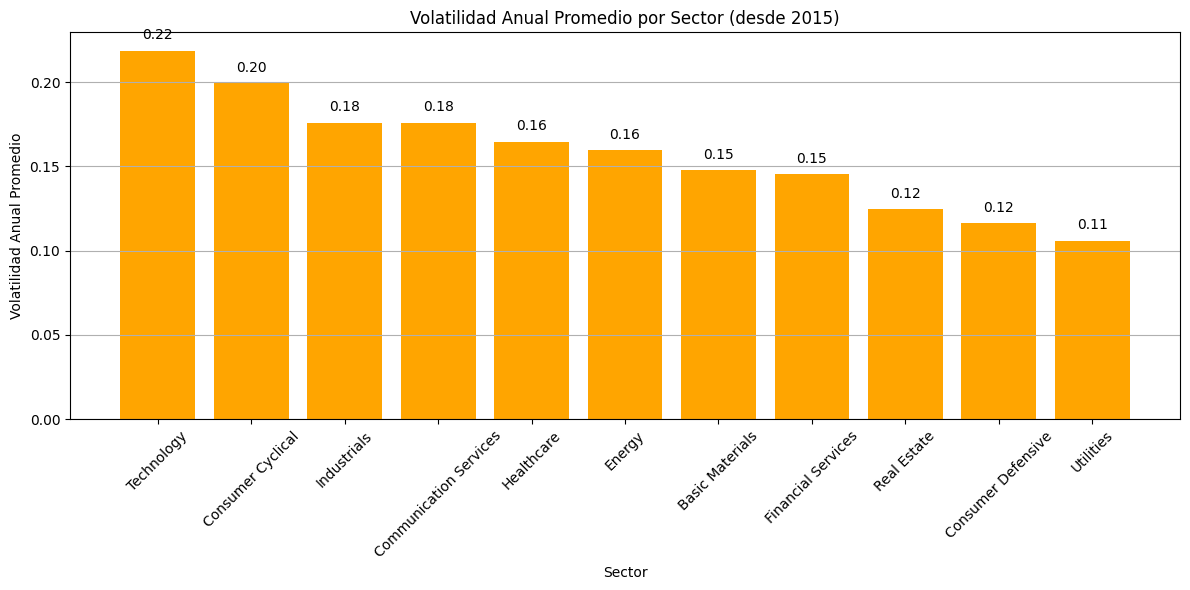

In [15]:
def get_volatilidad_por_sector():
    query = """
    SELECT
        e.sector,
        AVG(pv.var_annual::FLOAT) AS promedio_var_annual
    FROM
        precios_variaciones pv
    JOIN
        empresas e ON pv.ticker = e.ticker
    WHERE
        pv.var_annual IS NOT NULL
        AND pv.var_annual != 'NaN' -- <== EXCLUYE strings tipo 'NaN'
        AND e.sector IS NOT NULL
    GROUP BY
        e.sector
    ORDER BY
        promedio_var_annual DESC;
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Ejecutar función
volatilidad_sector = get_volatilidad_por_sector()
volatilidad_sector

# Crear gráfico de barras con etiquetas
plt.figure(figsize=(12, 6))
bars = plt.bar(volatilidad_sector['sector'], volatilidad_sector['promedio_var_annual'], color='orange')

# Etiquetas sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.2f}', ha='center', va='bottom')

plt.title('Volatilidad Anual Promedio por Sector (desde 2015)')
plt.xlabel('Sector')
plt.ylabel('Volatilidad Anual Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## 📊 Volatilidad Anual Promedio por Sector (desde 2015)

### 🥇 Sectores más volátiles
- **Technology**: 0.22  
  Sector altamente sensible a ciclos de innovación, tasas de interés y expectativas de crecimiento.

- **Industrials** (0.18) y **Consumer Cyclical** (0.20):  
  Fuertemente ligados al ciclo económico, lo que explica su mayor inestabilidad.

---

### 📉 Sectores más estables
- **Consumer Defensive**: 0.12  
  Empresas que ofrecen bienes esenciales; su demanda no cae en recesiones.

- **Real Estate** (0.12) y **Utilities** (0.11):  
  Modelos de ingresos predecibles, sensibles a tasas pero menos a shocks globales.

---

### 🧠 Conclusión
- Los sectores **más volátiles** ofrecen mayores oportunidades de ganancia, pero también más riesgo.
- Sectores **más estables** son ideales para estrategias defensivas o de largo plazo.



## 🧭 02.06 Análisis de Decisiones de Inversión por Sector

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\2816031170.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sectores_decision_final = pd.read_sql_query(query, conn)


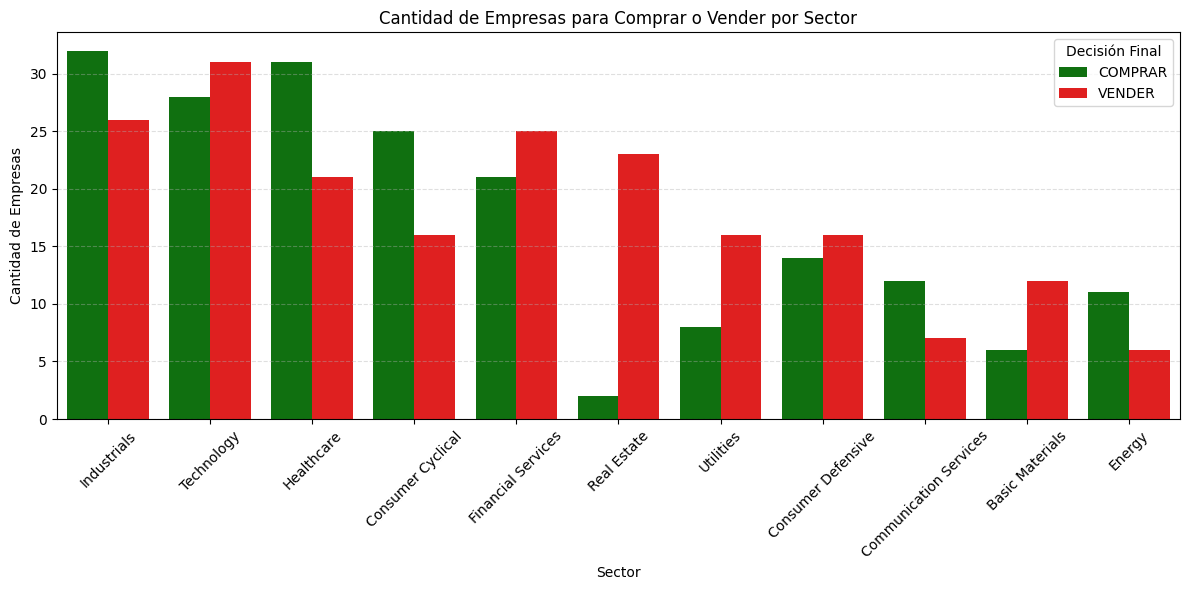

In [16]:
def get_decisiones_por_sector():
    query = """
    SELECT
        e.sector,
        r.decision_final,
        COUNT(*) AS cantidad
    FROM
        resumen_inversion r
    JOIN
        empresas e ON r.ticker = e.ticker
    WHERE
        r.decision_final IN ('COMPRAR', 'VENDER')
        AND e.sector IS NOT NULL
    GROUP BY
        e.sector, r.decision_final
    ORDER BY
        cantidad DESC;
    """
    conn = get_connection()
    df_sectores_decision_final = pd.read_sql_query(query, conn)
    conn.close()
    return df_sectores_decision_final

df_sectores_decision_final = get_decisiones_por_sector()
df_sectores_decision_final

# Obtener los datos
df_sectores_decision_final = get_decisiones_por_sector()

# Gráfico de barras apiladas por sector
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_sectores_decision_final,
    x="sector",
    y="cantidad",
    hue="decision_final",
    palette={"COMPRAR": "green", "VENDER": "red"}
)
plt.title("Cantidad de Empresas para Comprar o Vender por Sector")
plt.xlabel("Sector")
plt.ylabel("Cantidad de Empresas")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="Decisión Final")
plt.tight_layout()
plt.show()


## 🧭 Análisis de Decisiones de Inversión por Sector

El gráfico muestra la distribución de **empresas recomendadas para COMPRAR o VENDER**, segmentadas por sector económico. Se utilizaron los datos del campo `decision_final`, que refleja la evaluación integral de cada compañía en función de indicadores técnicos y fundamentales.

---

### 🔍 Observaciones Clave

#### ✅ Sectores con Mayor Número de Recomendaciones de **Compra**
- **Industrials** lidera con más de 30 empresas recomendadas para comprar, lo que sugiere un entorno favorable en productividad, valoraciones o crecimiento.
- **Healthcare** también destaca con más de 30 empresas sugeridas como oportunidades de compra, reflejando estabilidad y expectativas positivas.
- **Technology** y **Consumer Cyclical** completan los primeros puestos, aunque el sector tecnológico muestra un balance más parejo entre comprar y vender.

#### 🚨 Sectores con Mayor Número de Recomendaciones de **Venta**
- **Technology** aparece como el sector con mayor cantidad de recomendaciones de venta (más de 30), lo que podría reflejar **correcciones de precio, sobrevaloraciones** o incertidumbre reciente.
- **Financial Services** y **Real Estate** presentan una clara inclinación hacia ventas, lo cual podría vincularse con **sensibilidad a tasas de interés o ciclo económico**.
- **Utilities** y **Consumer Defensive** también presentan más señales de venta que de compra.

---

### 📊 Conclusión

- El gráfico sugiere un mayor optimismo en sectores cíclicos e industriales, mientras que sectores como **Real Estate**, **Financials** y **Technology** muestran señales mixtas o negativas.
- Esta visualización puede ser útil para orientar decisiones de cartera basadas en la **distribución sectorial de señales**.

--- 

> Este enfoque ayuda a entender **dónde se concentran las oportunidades o los riesgos**, facilitando una visión top-down para decisiones estratégicas.


# 03 Analisis temporal

## 📊03.01 Volumen Promedio Negociado por Sector (Mensual)

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\2787731069.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\2787731069.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1600x900 with 0 Axes>

c:\Users\Agus\Desktop\PFM\Proyecto-Final-Hack-io-limpio\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


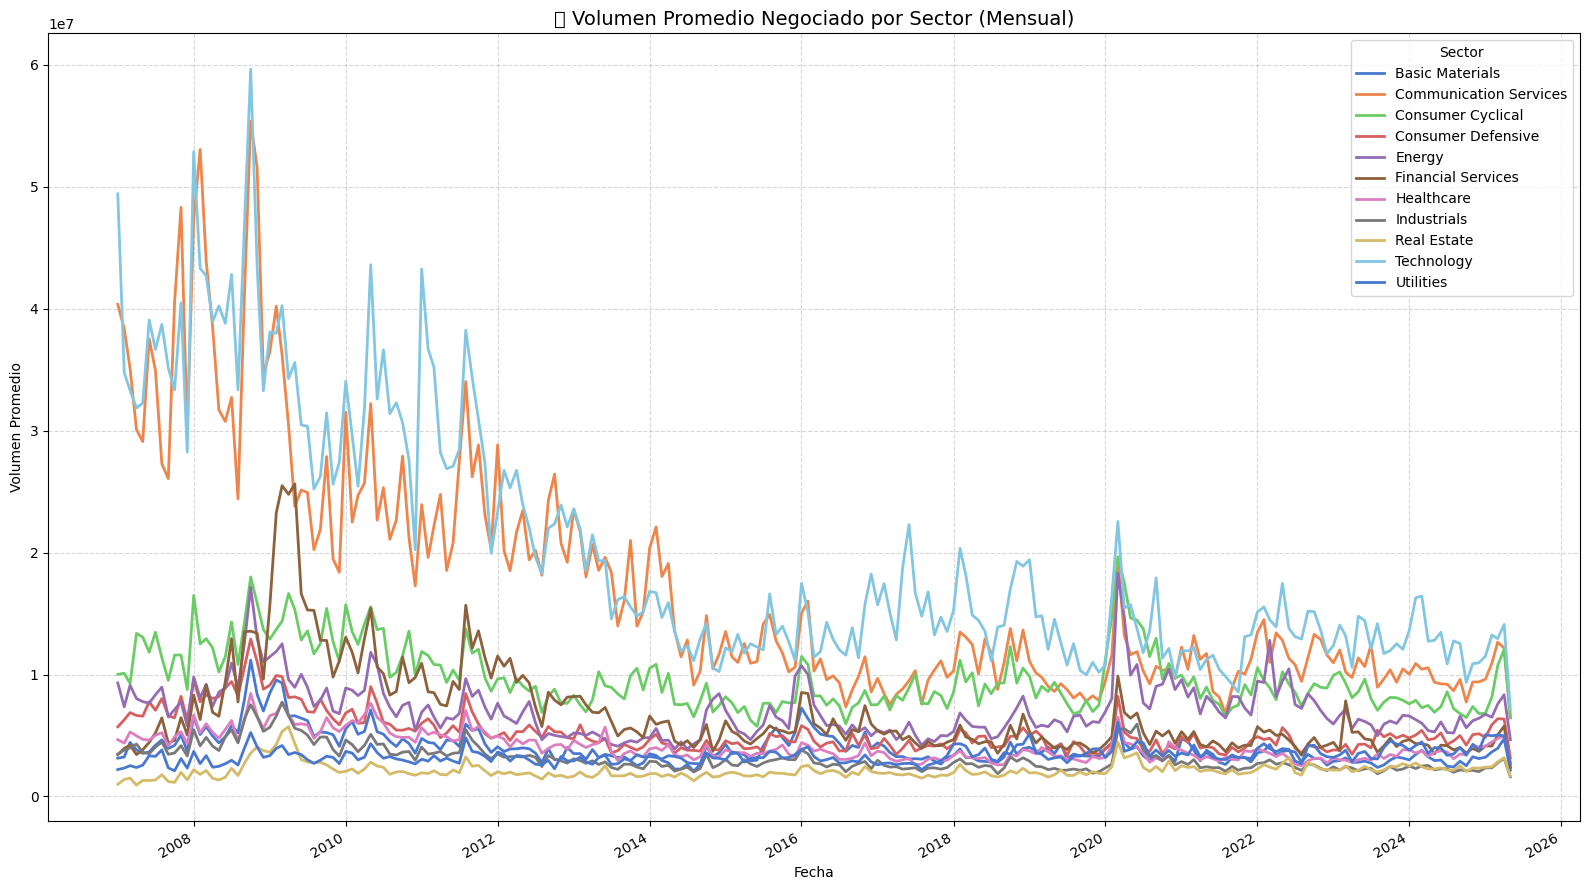

In [17]:
def get_volumen_mensual_por_sector():
    query = """
    SELECT
        DATE_TRUNC('month', pv.date) AS mes,
        e.sector,
        AVG(pv.volume) AS volumen_promedio
    FROM
        precios_historicos pv
    JOIN
        empresas e ON pv.ticker = e.ticker
    WHERE
        pv.volume IS NOT NULL
        AND e.sector IS NOT NULL
        AND pv.date >= '2007-01-01'
    GROUP BY
        mes, e.sector
    ORDER BY
        mes, e.sector;
    """
    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Ejecutar la función
volumen_sector_mensual_df = get_volumen_mensual_por_sector()
volumen_sector_mensual_df


# Pivot para gráfica
pivot_df = volumen_sector_mensual_df.pivot(index="mes", columns="sector", values="volumen_promedio")

# Gráfico
plt.figure(figsize=(16, 9))
pivot_df.plot(kind='line', linewidth=2, figsize=(16, 9))
plt.title("📊 Volumen Promedio Negociado por Sector (Mensual)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Volumen Promedio")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title="Sector")
plt.show()

## 📊 Análisis del Volumen Promedio Negociado por Sector (Mensual)

El siguiente gráfico muestra la evolución del **volumen promedio negociado** por sector en forma mensual desde 2007 hasta 2025.

---

### 🔍 Observaciones Clave

1. **📉 Caída progresiva post-crisis 2008**
   - Todos los sectores muestran una reducción constante del volumen tras la crisis financiera global.
   - Esto podría estar vinculado a una menor especulación y ajustes regulatorios posteriores al crash.

2. **📈 Pico en marzo de 2020**
   - Se observa un aumento repentino y sincronizado en todos los sectores durante el inicio de la pandemia del COVID-19.
   - Momento de alta incertidumbre y volatilidad que provocó mayores volúmenes de operación.

3. **💻 Tecnología y Comunicación dominan en volumen**
   - Sectores como **Technology** y **Communication Services** lideran consistentemente en volumen negociado.
   - Reflejan alta liquidez, popularidad entre inversores minoristas y gran capitalización.

4. **🏢 Utilities y Real Estate con volúmenes bajos**
   - Sectores más estables, con menor rotación de acciones.
   - Esto sugiere un comportamiento más conservador o institucional.

5. **📊 Estabilidad desde 2021 en adelante**
   - La mayoría de los sectores muestra estabilización del volumen negociado, con menores picos y mayor regularidad.
   - Puede indicar madurez del mercado o menor sensibilidad a shocks externos.

---

### 🧠 Conclusión

- El volumen negociado es un excelente proxy del **interés del mercado** y la **actividad especulativa**.
- Este análisis permite identificar momentos de **estrés financiero** o **cambio estructural**.
- Próximos pasos recomendados:
  - Agregar eventos históricos clave al gráfico.
  - Analizar volumen de empresas líderes por sector.
  - Combinar con métricas de volatilidad para enriquecer el diagnóstico.


## 📊 03.02 Análisis de la Volatilidad Histórica (`Volatility_20` vs `ATR_14`)

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1246389616.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=tickers)


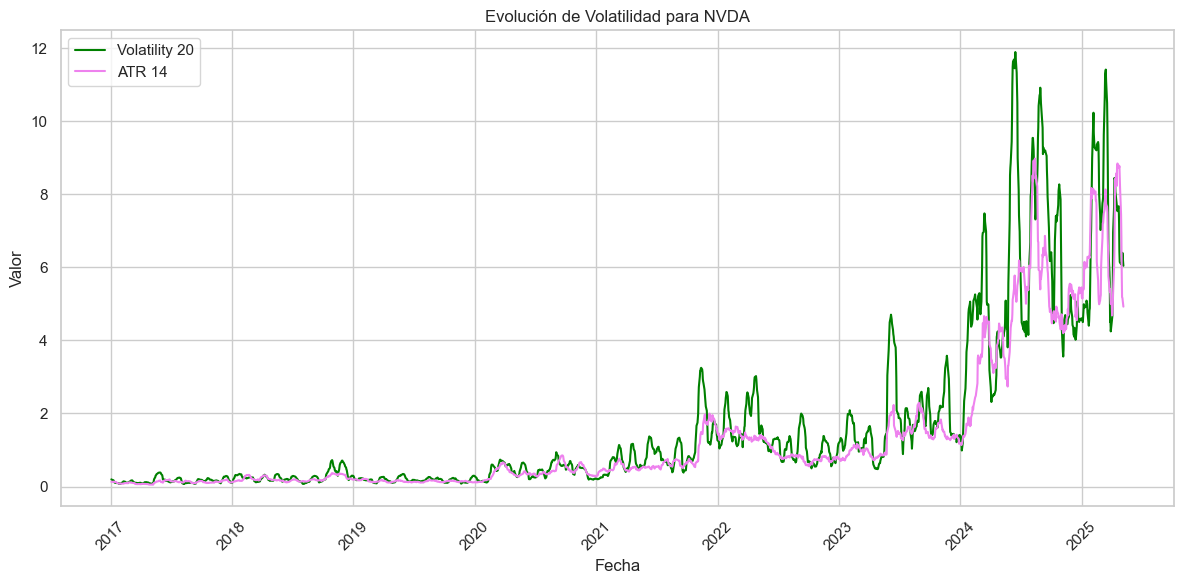

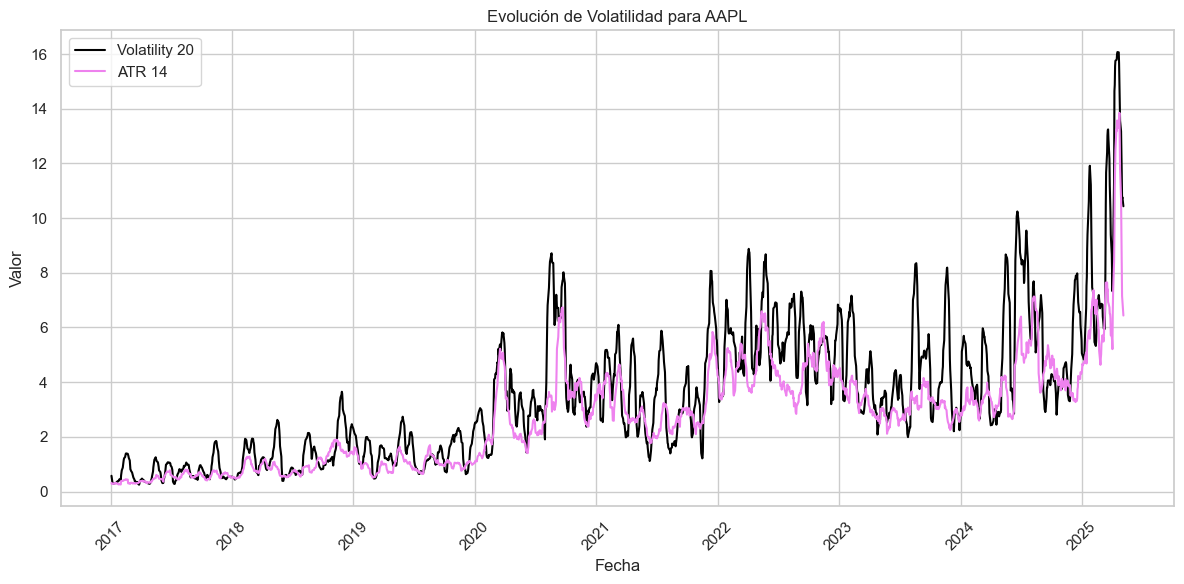

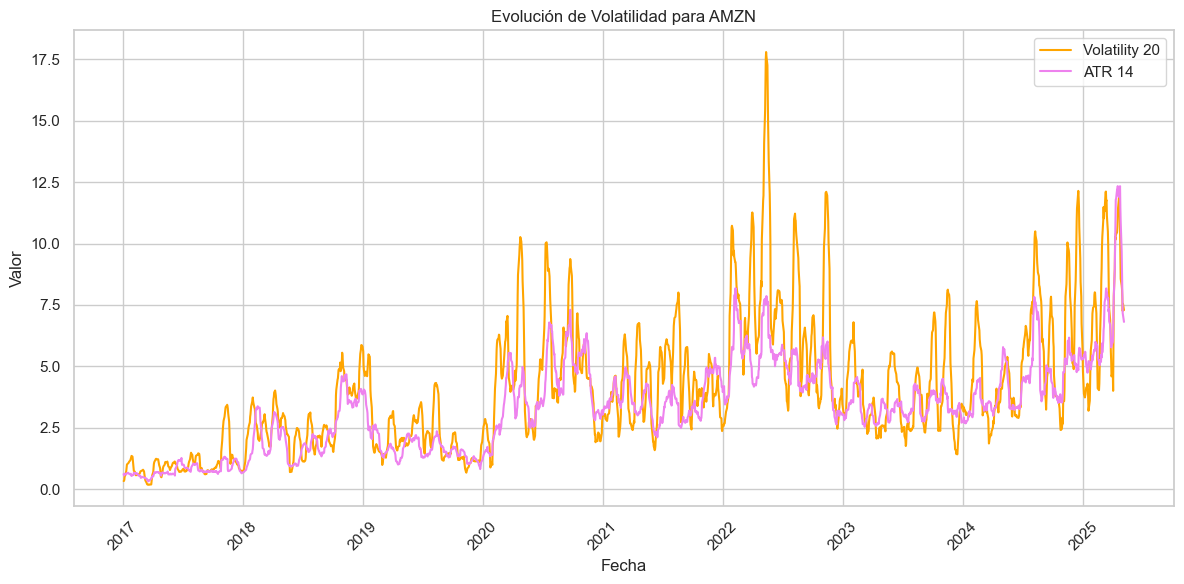

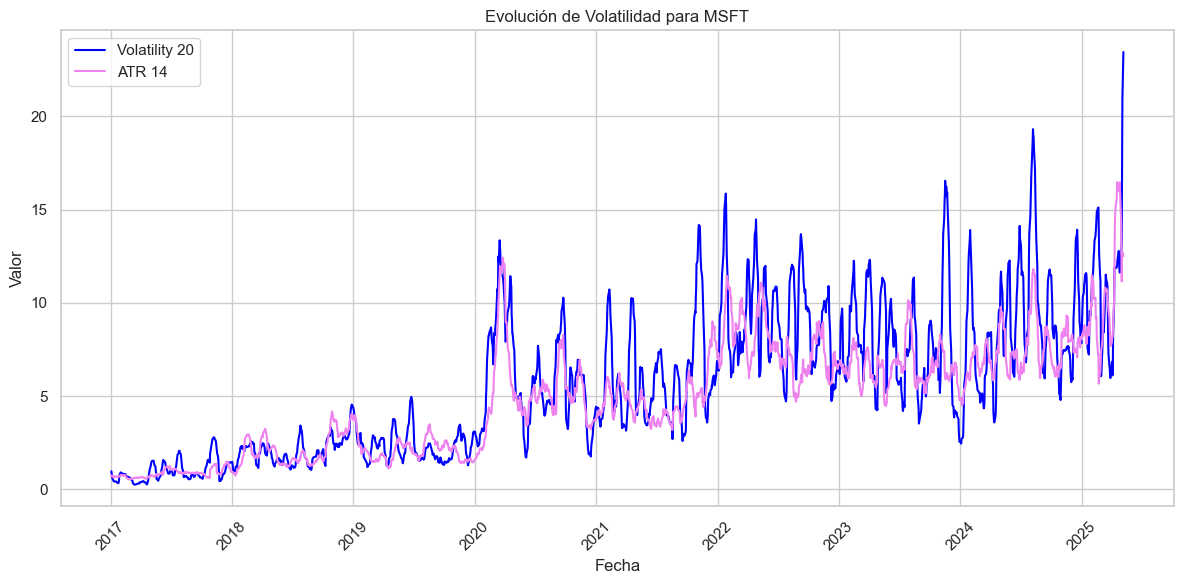

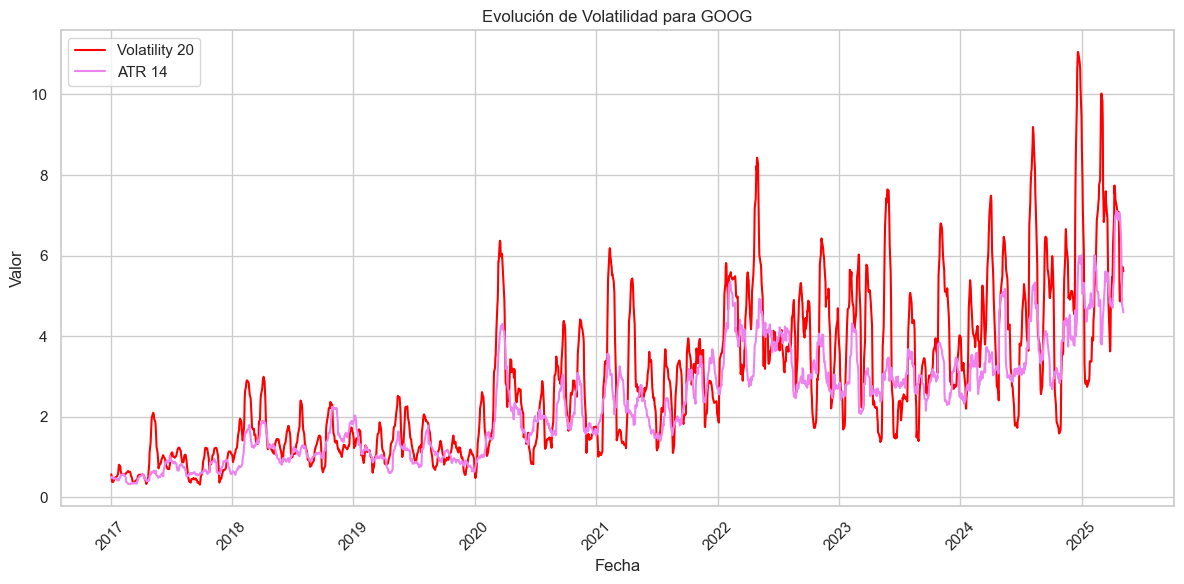

In [32]:
def get_volatilidad_empresas_claves():
    tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOG']
    
    placeholders = ','.join(['%s'] * len(tickers))
    
    query = f"""
    SELECT 
        it.date,
        it.ticker,
        it.volatility_20,
        it.atr_14
    FROM indicadores_tecnicos it
    WHERE it.ticker IN ({placeholders})
      AND it.volatility_20 IS NOT NULL
      AND it.atr_14 IS NOT NULL
      And it.date >= '2017-01-01'
    ORDER BY it.date
    """

    conn = get_connection()
    df = pd.read_sql_query(query, conn, params=tickers)
    conn.close()
    return df


# Ejecutar la función
volatilidad_empresas_claves_df = get_volatilidad_empresas_claves()

# eliminamos missing values
volatilidad_empresas_claves_df = volatilidad_empresas_claves_df.dropna()
volatilidad_empresas_claves_df

# Asegurarse de que la columna 'date' es de tipo datetime
volatilidad_empresas_claves_df['date'] = pd.to_datetime(volatilidad_empresas_claves_df['date'])

color_dict = {
    'MSFT': 'blue',
    'AAPL': 'black',
    'AMZN': 'orange',
    'GOOG': 'red',
    'NVDA': 'green'
}

# Gráfico individual con color por empresa
for ticker in volatilidad_empresas_claves_df['ticker'].unique():
    sub_df = volatilidad_empresas_claves_df[volatilidad_empresas_claves_df['ticker'] == ticker]

    plt.figure(figsize=(12, 6))
    plt.plot(sub_df['date'], sub_df['volatility_20'], label='Volatility 20', color=color_dict[ticker])
    plt.plot(sub_df['date'], sub_df['atr_14'], label='ATR 14', color='violet')
    plt.title(f"Evolución de Volatilidad para {ticker}")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## 📈 Análisis de la Volatilidad Histórica (2017–2025)

Los siguientes gráficos muestran la evolución de la volatilidad para cinco empresas tecnológicas líderes utilizando dos indicadores técnicos:

- **`Volatility_20`**: calcula la desviación estándar de los retornos diarios en una ventana de 20 días. Es un indicador más **reactivo y sensible** a cambios repentinos.
- **`ATR_14` (Average True Range)**: mide el rango verdadero promedio en una ventana de 14 días. Es más **suave y estable**, capturando la magnitud de movimientos sin importar su dirección.

Ambos indicadores permiten evaluar la **incertidumbre del mercado**, pero lo hacen con enfoques distintos. A continuación, se presentan los análisis individuales:

---

### 🟦 Microsoft (MSFT)

- Muestra una tendencia ascendente clara desde 2018, con fuertes picos en 2020 y otro repunte post-2023.
- `Volatility_20` responde más abruptamente a eventos extremos.
- `ATR_14` mantiene una forma similar pero más suavizada, ideal para seguimiento de tendencia.

---

### ⚫Apple (AAPL)

- Volatilidad creciente desde 2020, con mayor intensidad a partir de 2023.
- Ambos indicadores están altamente correlacionados, aunque `Volatility_20` marca más picos.
- El comportamiento refleja un entorno más volátil en años recientes.

---

### 🟧 Amazon (AMZN)

- Volatilidad con varios máximos destacados en 2021 y 2022.
- `Volatility_20` presenta más dispersión, lo que revela movimientos bruscos puntuales.
- `ATR_14` capta mejor la tendencia base sin tanto ruido.

---

### 🟥 Google (GOOG)

- Evolución moderada hasta 2020, seguida por un aumento sostenido hasta 2025.
- `Volatility_20` presenta picos que indican momentos de incertidumbre de corto plazo.
- `ATR_14` permite visualizar una progresión más estructurada de la volatilidad.

---

### 🟩 NVIDIA (NVDA)

- Caso más marcado: casi sin volatilidad antes de 2020, luego crecimiento explosivo.
- Desde 2024 en adelante se observan niveles históricamente altos en ambos indicadores.
- `Volatility_20` destaca los movimientos extremos, mientras que `ATR_14` los amortigua visualmente.

---



## 🔄 03.03 Análisis de la Rotación Sectorial Trimestre a Trimestre (2007–2025)

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\210491269.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


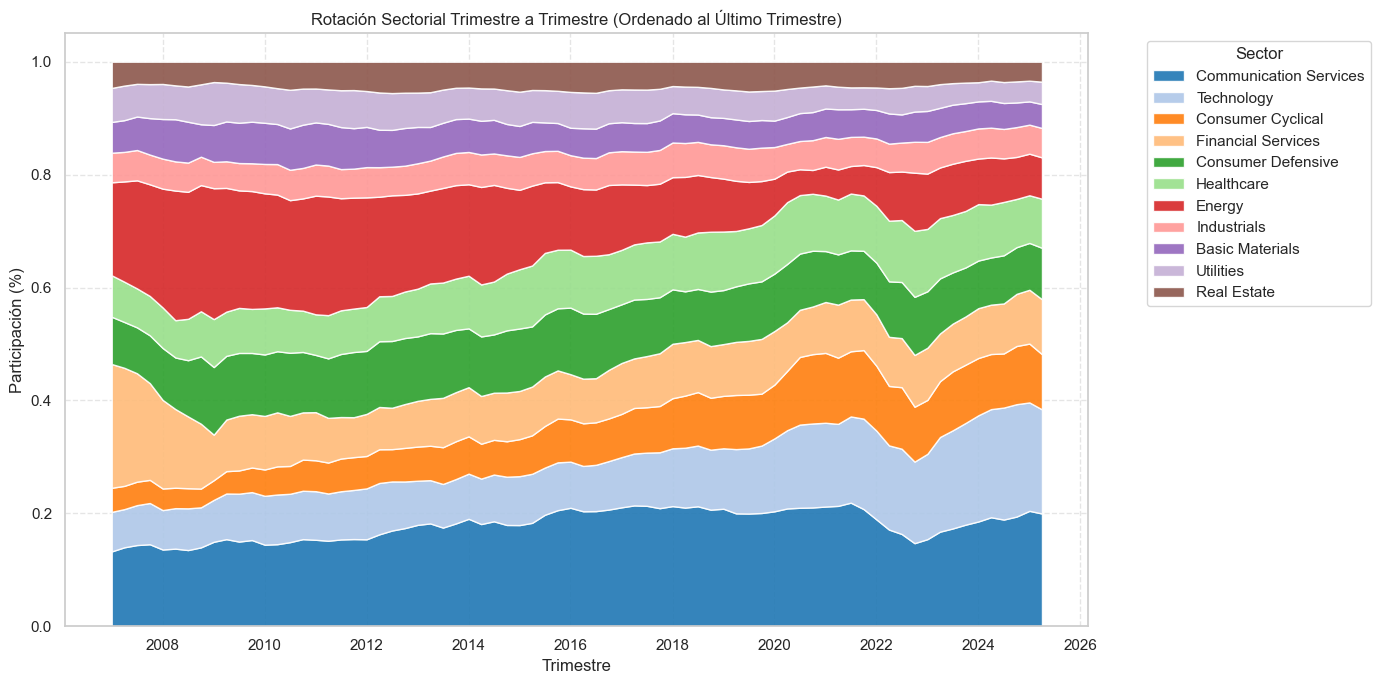

In [42]:
def get_rotacion_sectorial_trimestral():
    import pandas as pd

    query = """
    WITH market_cap_diario AS (
        SELECT 
            DATE_TRUNC('quarter', ph.date) AS trimestre,
            e.sector,
            (f.acciones_circulacion * ph.close) AS market_cap
        FROM precios_historicos ph
        JOIN empresas e ON ph.ticker = e.ticker
        JOIN indicadores_fundamentales f ON ph.ticker = f.ticker
        WHERE ph.close IS NOT NULL AND f.acciones_circulacion IS NOT NULL
    ),
    sector_trimestral AS (
        SELECT 
            trimestre,
            sector,
            AVG(market_cap) AS avg_sector_market_cap
        FROM market_cap_diario
        GROUP BY trimestre, sector
    ),
    total_trimestral AS (
        SELECT 
            trimestre,
            SUM(avg_sector_market_cap) AS total_market_cap
        FROM sector_trimestral
        GROUP BY trimestre
    )
    SELECT 
        s.trimestre,
        s.sector,
        s.avg_sector_market_cap,
        t.total_market_cap,
        s.avg_sector_market_cap / t.total_market_cap AS participacion
    FROM sector_trimestral s
    JOIN total_trimestral t ON s.trimestre = t.trimestre
    ORDER BY s.trimestre, s.sector;
    """

    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Ejecutar
rotacion_sectorial_df = get_rotacion_sectorial_trimestral()
rotacion_sectorial_df

# Paso 1: preparar los datos pivotados
rotacion_sectorial_df = rotacion_sectorial_df.sort_values('trimestre')
ultimo_trimestre = rotacion_sectorial_df['trimestre'].max()

# Ordenar sectores por participación en el último trimestre (de mayor a menor)
sector_order = (
    rotacion_sectorial_df[rotacion_sectorial_df['trimestre'] == ultimo_trimestre]
    .sort_values('participacion', ascending=False)['sector']
    .tolist()
)

# Pivotear y reordenar
df_pivot = rotacion_sectorial_df.pivot(index='trimestre', columns='sector', values='participacion')
df_pivot = df_pivot[sector_order]

# Paso 2: graficar manualmente para mantener orden y leyenda
fig, ax = plt.subplots(figsize=(14, 7))

# Colores para que se vean bien y distintos
colors = plt.get_cmap('tab20').colors[:len(sector_order)]

# Graficar área apilada en orden correcto
stack = ax.stackplot(df_pivot.index, df_pivot.T.values, labels=sector_order, colors=colors, alpha=0.9)

# Estética
ax.set_title('Rotación Sectorial Trimestre a Trimestre (Ordenado al Último Trimestre)')
ax.set_ylabel('Participación (%)')
ax.set_xlabel('Trimestre')
ax.grid(True, linestyle='--', alpha=0.5)

# Leyenda en orden correcto
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Sector", labels=sector_order)

plt.tight_layout()
plt.show()

## 🔄 Análisis de la Rotación Sectorial Trimestre a Trimestre (2007–2025)

El gráfico muestra la evolución de la participación relativa de los sectores económicos en la capitalización bursátil total, calculada como:

**Market Cap diario = Acciones en circulación × Precio de cierre**

Agrupando por trimestres y ordenando los sectores de **mayor a menor participación al último trimestre disponible**, se observan claramente las dinámicas de **rotación sectorial** a lo largo del tiempo.

---

### 📊 Principales observaciones:

- **🟦 Communication Services** se posiciona como el sector con mayor peso en el último trimestre, mostrando un crecimiento constante desde 2010, especialmente notorio a partir de 2018. Esto puede reflejar la consolidación de empresas como Alphabet y Meta dentro de esta categoría.
  
- **🟦 Technology** mantiene un lugar destacado, aunque pierde participación relativa desde 2021. Esta contracción podría reflejar una toma de ganancias o un rebalanceo hacia sectores más defensivos tras años de dominio post-pandemia.

- **🟧 Consumer Cyclical** y **🟧 Financial Services** muestran un crecimiento sostenido en su peso relativo, indicando una rotación hacia sectores sensibles al ciclo económico, tal vez en anticipación a recuperación o expansión económica.

- **🟩 Healthcare** conserva una participación estable y robusta, siendo un sector típicamente defensivo, atractivo en tiempos de incertidumbre o recesión.

- **🟥 Energy**, que había perdido peso desde 2008, muestra una **recuperación significativa desde 2021**, probablemente relacionada con el aumento de precios de commodities y la crisis energética global.

- **🟫 Real Estate**, **🟪 Utilities** y **🟪 Basic Materials** se mantienen con participación relativamente baja y estable, reflejando su perfil más conservador y menos dinámico en cuanto a rotación.

---

### 🧠 Interpretación estratégica:

- La **rotación desde Tecnología hacia sectores cíclicos y de servicios de comunicación** sugiere una mayor exposición al crecimiento económico futuro por parte de los inversores.

- La revalorización de sectores como **Energy y Financials** puede estar asociada a expectativas inflacionarias, subas de tasas y recuperación post-COVID.

- Esta visualización es clave para detectar ciclos económicos, permitiendo identificar momentos en los que los inversores migran desde sectores defensivos hacia ofensivos (y viceversa).

---

### 📌 Conclusión

Este gráfico permite visualizar de forma clara y dinámica **cómo cambian las preferencias del mercado a lo largo del tiempo**, mostrando evidencia concreta de **rotación sectorial** como respuesta a distintos contextos económicos y financieros.


C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\3675207587.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\3675207587.py:73: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Agus\Desktop\PFM\Proyecto-Final-Hack-io-limpio\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


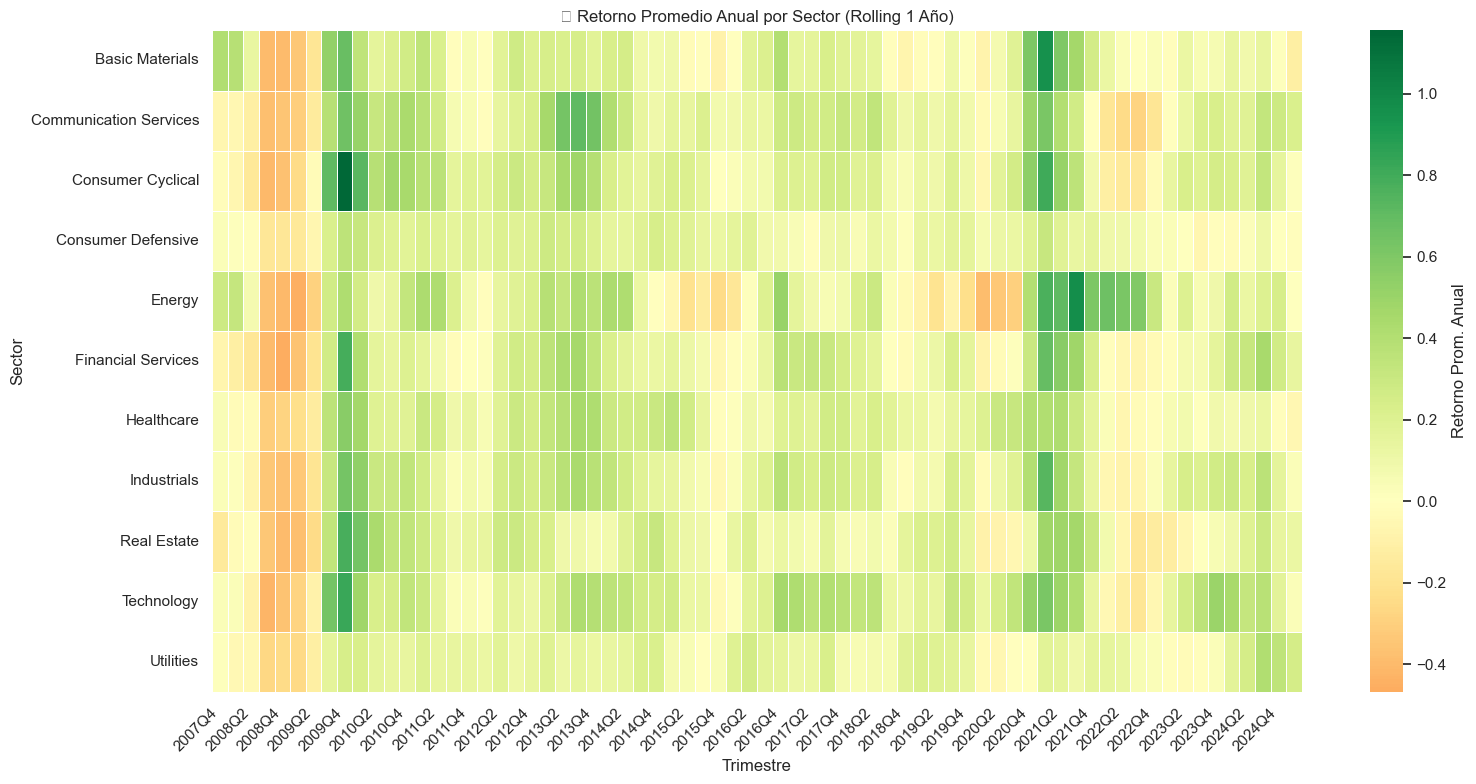

In [53]:
def get_retornos_anuales_por_sector():
    import pandas as pd

    query = """
    WITH precios_con_sector AS (
        SELECT 
            ph.date,
            ph.ticker,
            e.sector,
            ph.close,
            LAG(ph.close, 252) OVER (PARTITION BY ph.ticker ORDER BY ph.date) AS close_1y_ago
        FROM precios_historicos ph
        JOIN empresas e ON ph.ticker = e.ticker
    ),
    retornos_diarios AS (
        SELECT
            date,
            sector,
            (close - close_1y_ago) / NULLIF(close_1y_ago, 0) AS retorno_anual
        FROM precios_con_sector
        WHERE close IS NOT NULL AND close_1y_ago IS NOT NULL
    ),
    retornos_trimestrales AS (
        SELECT
            DATE_TRUNC('quarter', date) AS trimestre,
            sector,
            AVG(retorno_anual) AS retorno_prom_sector
        FROM retornos_diarios
        GROUP BY trimestre, sector
    )
    SELECT *
    FROM retornos_trimestrales
    ORDER BY trimestre, sector;
    """

    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Ejecutar la función
retornos_sectoriales_df = get_retornos_anuales_por_sector()
retornos_sectoriales_df
# Forzar a datetime, corrigiendo zona horaria si es necesario
retornos_sectoriales_df['trimestre'] = pd.to_datetime(retornos_sectoriales_df['trimestre'], utc=True, errors='coerce')

# Eliminar zona horaria
retornos_sectoriales_df['trimestre'] = retornos_sectoriales_df['trimestre'].dt.tz_localize(None)

# Formatear como "YYYY-Qx"
retornos_sectoriales_df['trimestre_str'] = retornos_sectoriales_df['trimestre'].dt.to_period('Q').astype(str)

# Pivotear para heatmap
heatmap_df = retornos_sectoriales_df.pivot(index='sector', columns='trimestre_str', values='retorno_prom_sector')
heatmap_df = heatmap_df.sort_index(axis=1)

# Graficar heatmap limpio
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_df,
    cmap='RdYlGn',
    center=0,
    annot=False,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Retorno Prom. Anual'}
)

plt.title('📈 Retorno Promedio Anual por Sector (Rolling 1 Año)')
plt.xlabel('Trimestre')
plt.ylabel('Sector')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## 📈 Análisis de Retorno Promedio Anual por Sector (Rolling 1 Año)

El siguiente gráfico tipo heatmap muestra el **retorno promedio anual (móvil)** para cada sector económico, trimestre a trimestre, desde 2007 hasta 2025. El cálculo se basa en una ventana móvil de 252 días (aprox. un año bursátil), y se expresa como:

**Retorno Anual = Precio Actual - Precio Hace 1 Año\Precio Hace 1 Año**

Este análisis permite visualizar qué sectores han liderado o rezagado en distintos momentos del ciclo económico y de mercado.

---

### 🧠 Claves de interpretación:

- **Colores verdes oscuros** indican trimestres de alta rentabilidad sectorial (top performers).
- **Colores naranjas o rojizos** representan retornos negativos o desempeño débil.
- **Colores neutros claros** indican retorno cercano a cero.

---

### 🔍 Observaciones destacadas:

- **2020–2021**: Periodo post-pandemia donde sectores como **Technology**, **Industrials**, y especialmente **Energy** mostraron retornos excepcionalmente altos. El tono verde intenso confirma el rebote económico.
  
- **2008–2009**: Claramente se observa un amplio deterioro en todos los sectores durante la crisis financiera global, con colores anaranjados predominantes en múltiples sectores como **Financial Services** y **Real Estate**.

- **Healthcare** y **Consumer Defensive** mantienen un desempeño más **estable y menos volátil** en casi todos los trimestres, lo que refuerza su rol defensivo en las carteras.

- **Communication Services** y **Technology** tienen una performance **cíclica**, con momentos de liderazgo claros en 2010–2011, 2018, y 2021.

- **Energy** es el sector con mayores oscilaciones: fue uno de los peores en 2014 y 2020, pero **uno de los mejores en 2021–2022**.

---

### 📌 Conclusión

Este heatmap es una herramienta visual poderosa para detectar **tendencias rotativas en el liderazgo sectorial**, evaluar ciclos económicos y guiar decisiones de asset allocation o sector rotation. Los sectores no son estáticos: evolucionan, reaccionan ante el entorno macroeconómico y cambian su atractivo relativo con el tiempo.


## 📊 03.04 Comparativo de Efectividad del RSI como Señal Técnica

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\3137080632.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\3137080632.py:82: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.tight_layout()
c:\Users\Agus\Desktop\PFM\Proyecto-Final-Hack-io-limpio\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


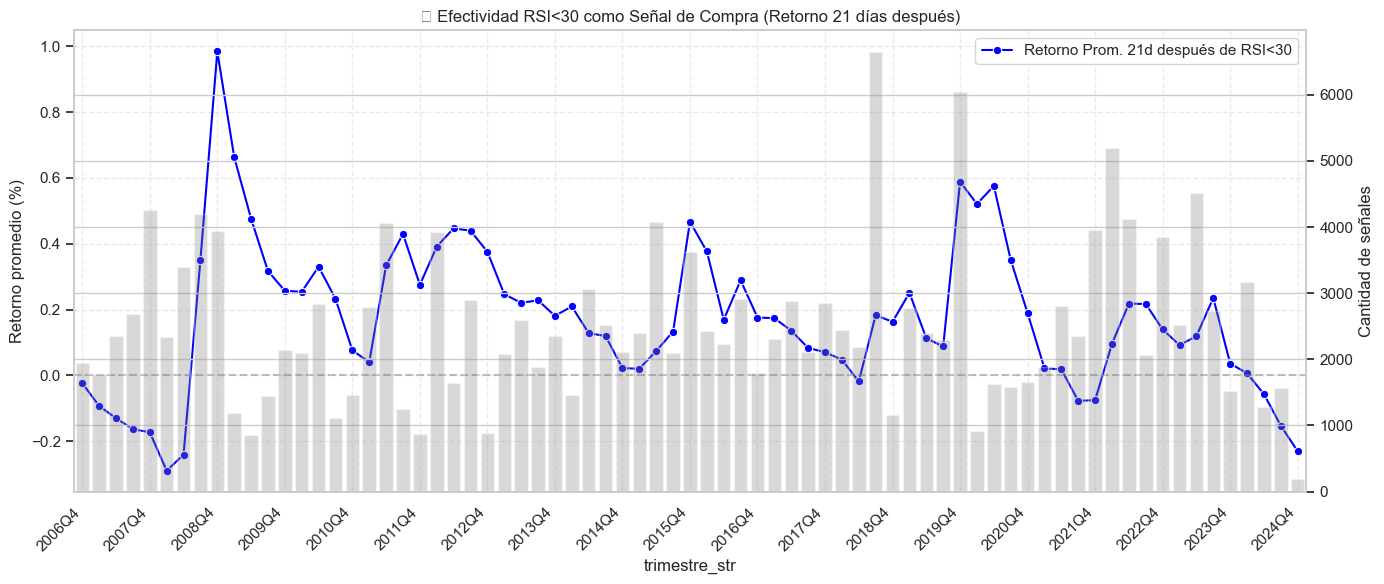

In [63]:
def evaluar_efectividad_rsi():
    import pandas as pd

    query = """
    WITH rsi_señales AS (
        SELECT 
            it.ticker,
            it.date AS fecha_senal,
            ph1.close AS precio_senal,
            LEAD(ph1.close, 21) OVER (PARTITION BY it.ticker ORDER BY it.date) AS precio_21d_despues
        FROM indicadores_tecnicos it
        JOIN precios_historicos ph1 ON it.ticker = ph1.ticker AND it.date = ph1.date
        WHERE it.rsi_14 < 30
    ),
    retornos_senal AS (
        SELECT 
            fecha_senal,
            ticker,
            DATE_TRUNC('quarter', fecha_senal) AS trimestre,
            (precio_21d_despues - precio_senal) / NULLIF(precio_senal, 0) AS retorno_21d
        FROM rsi_señales
        WHERE precio_senal IS NOT NULL AND precio_21d_despues IS NOT NULL
    )
    SELECT 
        trimestre,
        COUNT(*) AS cantidad_senales,
        AVG(retorno_21d) AS retorno_promedio_post_senal
    FROM retornos_senal
    GROUP BY trimestre
    ORDER BY trimestre;
    """

    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Ejecutar
efectividad_df = evaluar_efectividad_rsi()
efectividad_df

# Usar trimestre_str para eje X en ambos plots
efectividad_df['trimestre'] = pd.to_datetime(efectividad_df['trimestre'], utc=True).dt.tz_localize(None)
efectividad_df['trimestre_str'] = efectividad_df['trimestre'].dt.to_period('Q').astype(str)

# Crear figura
fig, ax1 = plt.subplots(figsize=(14, 6))

# Línea: retorno promedio post-señal
sns.lineplot(
    data=efectividad_df,
    x='trimestre_str',  # ← usar texto para evitar conflictos
    y='retorno_promedio_post_senal',
    marker='o',
    ax=ax1,
    color='blue',
    label='Retorno Prom. 21d después de RSI<30'
)

ax1.set_ylabel('Retorno promedio (%)')
ax1.axhline(0, linestyle='--', color='gray', alpha=0.5)
ax1.set_title('📈 Efectividad RSI<30 como Señal de Compra (Retorno 21 días después)')
ax1.grid(True, linestyle='--', alpha=0.4)

# Barras: cantidad de señales (2do eje)
ax2 = ax1.twinx()
sns.barplot(
    data=efectividad_df,
    x='trimestre_str',  # ← mismo eje X textual
    y='cantidad_senales',
    alpha=0.3,
    ax=ax2,
    color='gray'
)
ax2.set_ylabel('Cantidad de señales')
# Mostrar solo cada 4 etiquetas
skip = 4
xticks = efectividad_df['trimestre_str']
ax1.set_xticks(range(0, len(xticks), skip))
ax1.set_xticklabels(xticks[::skip], rotation=45, ha='right')

fig.tight_layout()
plt.show()


C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1471113241.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1471113241.py:82: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.tight_layout()
c:\Users\Agus\Desktop\PFM\Proyecto-Final-Hack-io-limpio\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


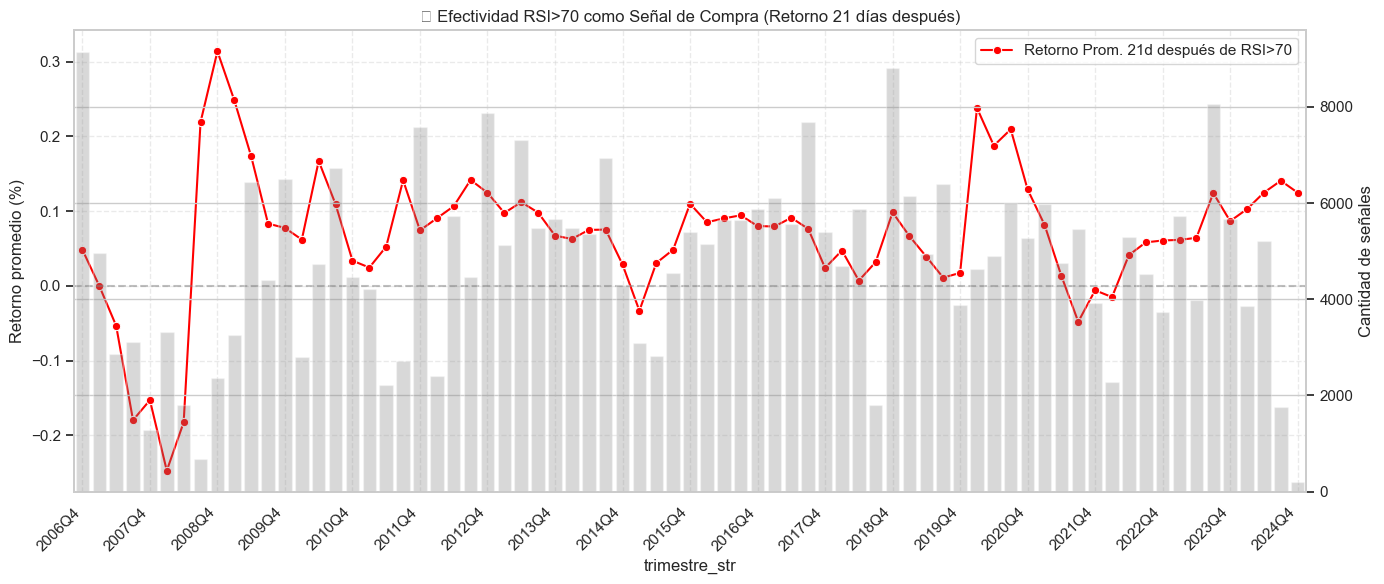

In [66]:
def evaluar_efectividad_rsi_alto():
    import pandas as pd

    query = """
    WITH rsi_altos AS (
        SELECT 
            it.ticker,
            it.date AS fecha_senal,
            ph1.close AS precio_senal,
            LEAD(ph1.close, 21) OVER (PARTITION BY it.ticker ORDER BY it.date) AS precio_21d_despues
        FROM indicadores_tecnicos it
        JOIN precios_historicos ph1 ON it.ticker = ph1.ticker AND it.date = ph1.date
        WHERE it.rsi_14 > 70
    ),
    retornos_senal AS (
        SELECT 
            fecha_senal,
            ticker,
            DATE_TRUNC('quarter', fecha_senal) AS trimestre,
            (precio_21d_despues - precio_senal) / NULLIF(precio_senal, 0) AS retorno_21d
        FROM rsi_altos
        WHERE precio_senal IS NOT NULL AND precio_21d_despues IS NOT NULL
    )
    SELECT 
        trimestre,
        COUNT(*) AS cantidad_senales,
        AVG(retorno_21d) AS retorno_promedio_post_senal
    FROM retornos_senal
    GROUP BY trimestre
    ORDER BY trimestre;
    """

    conn = get_connection()
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Ejecutar
efectividad_rsi_alto_df = evaluar_efectividad_rsi_alto()
efectividad_rsi_alto_df

# Usar trimestre_str para eje X en ambos plots
efectividad_rsi_alto_df['trimestre'] = pd.to_datetime(efectividad_rsi_alto_df['trimestre'], utc=True).dt.tz_localize(None)
efectividad_rsi_alto_df['trimestre_str'] = efectividad_rsi_alto_df['trimestre'].dt.to_period('Q').astype(str)

# Crear figura
fig, ax1 = plt.subplots(figsize=(14, 6))

# Línea: retorno promedio post-señal
sns.lineplot(
    data=efectividad_rsi_alto_df,
    x='trimestre_str',  # ← usar texto para evitar conflictos
    y='retorno_promedio_post_senal',
    marker='o',
    ax=ax1,
    color='red',
    label='Retorno Prom. 21d después de RSI>70'
)

ax1.set_ylabel('Retorno promedio (%)')
ax1.axhline(0, linestyle='--', color='gray', alpha=0.5)
ax1.set_title('📈 Efectividad RSI>70 como Señal de Compra (Retorno 21 días después)')
ax1.grid(True, linestyle='--', alpha=0.4)

# Barras: cantidad de señales (2do eje)
ax2 = ax1.twinx()
sns.barplot(
    data=efectividad_rsi_alto_df,
    x='trimestre_str',  # ← mismo eje X textual
    y='cantidad_senales',
    alpha=0.3,
    ax=ax2,
    color='gray'
)
ax2.set_ylabel('Cantidad de señales')
# Mostrar solo cada 4 etiquetas
skip = 4
xticks = efectividad_rsi_alto_df['trimestre_str']
ax1.set_xticks(range(0, len(xticks), skip))
ax1.set_xticklabels(xticks[::skip], rotation=45, ha='right')

fig.tight_layout()
plt.show()


## 📊 Comparativo de Efectividad del RSI como Señal Técnica

### 🔵 RSI < 30 (Señal de Compra por Sobreventa)

- **Interpretación técnica**: Niveles por debajo de 30 indican sobreventa, lo que sugiere una posible reversión alcista.
- **Comportamiento observado**:
  - Entre 2008 y 2012, la señal fue **altamente efectiva**, con retornos promedio posteriores que en varios trimestres superaron el +0.5.
  - En trimestres más recientes (2022–2024), los retornos fueron **más bajos o negativos**, reflejando menor eficacia en contextos de alta volatilidad estructural.
  - La cantidad de señales tiende a aumentar en **momentos de corrección generalizada**, como ocurrió en 2020 y 2022.

---

### 🔴 RSI > 70 (Señal de Venta por Sobrecompra)

- **Interpretación técnica**: RSI superior a 70 indica sobrecompra, tradicionalmente asociado a correcciones o techos temporales.
- **Comportamiento observado**:
  - A diferencia de la teoría, la mayoría de los trimestres posteriores a RSI>70 muestran **retornos positivos**, especialmente en años de fuerte tendencia alcista.
  - Esto sugiere que en contextos de mercado estructuralmente alcistas, un RSI alto **no necesariamente anticipa una caída**, y puede ser parte de una fase de continuación.
  - Se observó una **mayor cantidad de señales**, mostrando que los activos pasan más tiempo en sobrecompra que en sobreventa.

---

### 📌 Conclusiones Comparativas

| Métrica                      | RSI < 30                        | RSI > 70                          |
|-----------------------------|----------------------------------|-----------------------------------|
| Tipo de señal               | Potencial de compra              | Potencial de venta                |
| Retornos observados         | Positivos en fases post-crisis   | Positivos en general              |
| Comportamiento reciente     | Menor eficacia                   | Estabilidad y consistencia        |
| Frecuencia de señales       | Baja (crisis o caídas fuertes)   | Alta (en mercados alcistas)       |

---

### 🧠 Insight Final

> Las reglas tradicionales del RSI requieren **contextualización**.  
> RSI<30 puede ser útil tras correcciones bruscas, mientras que RSI>70 **no debería usarse como señal de venta aislada** en mercados alcistas.  
> **Complementar estas señales con análisis de tendencia o fundamentales puede mejorar su utilidad.**

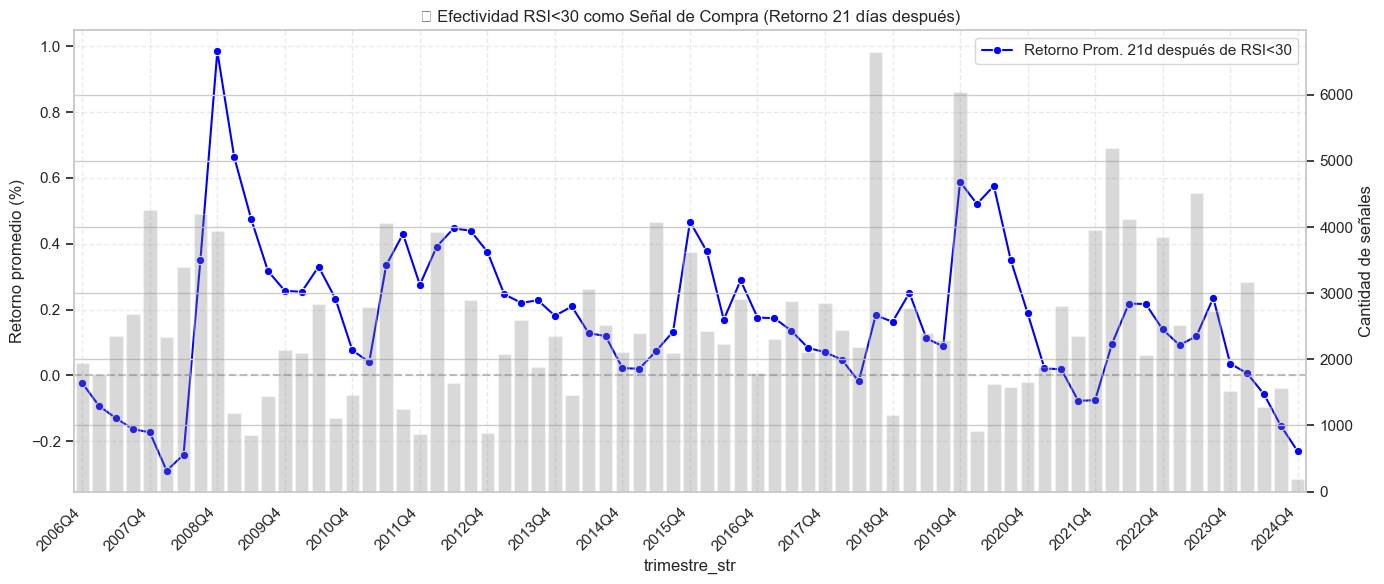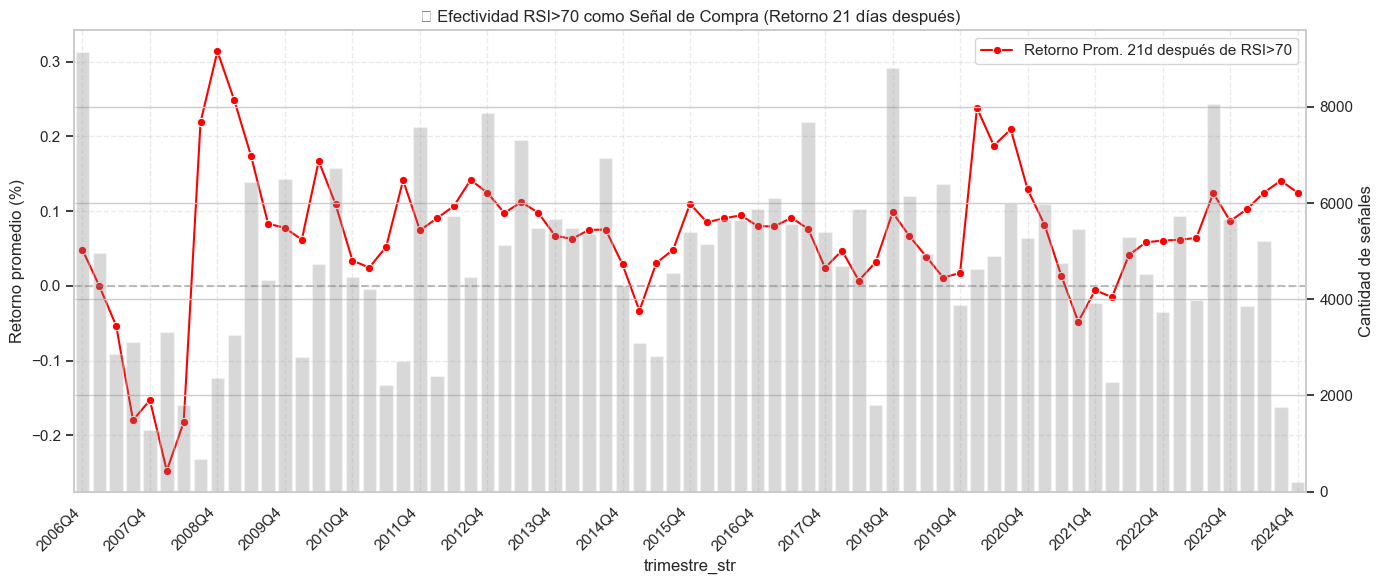

# 📊 03.05 Análisis de Cruces SMA20 vs. SMA50 en 5 Acciones Clave

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\230332141.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=tickers)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\230332141.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Agus\Desktop\PFM\Proyecto-Final-Hack-io-limpio\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


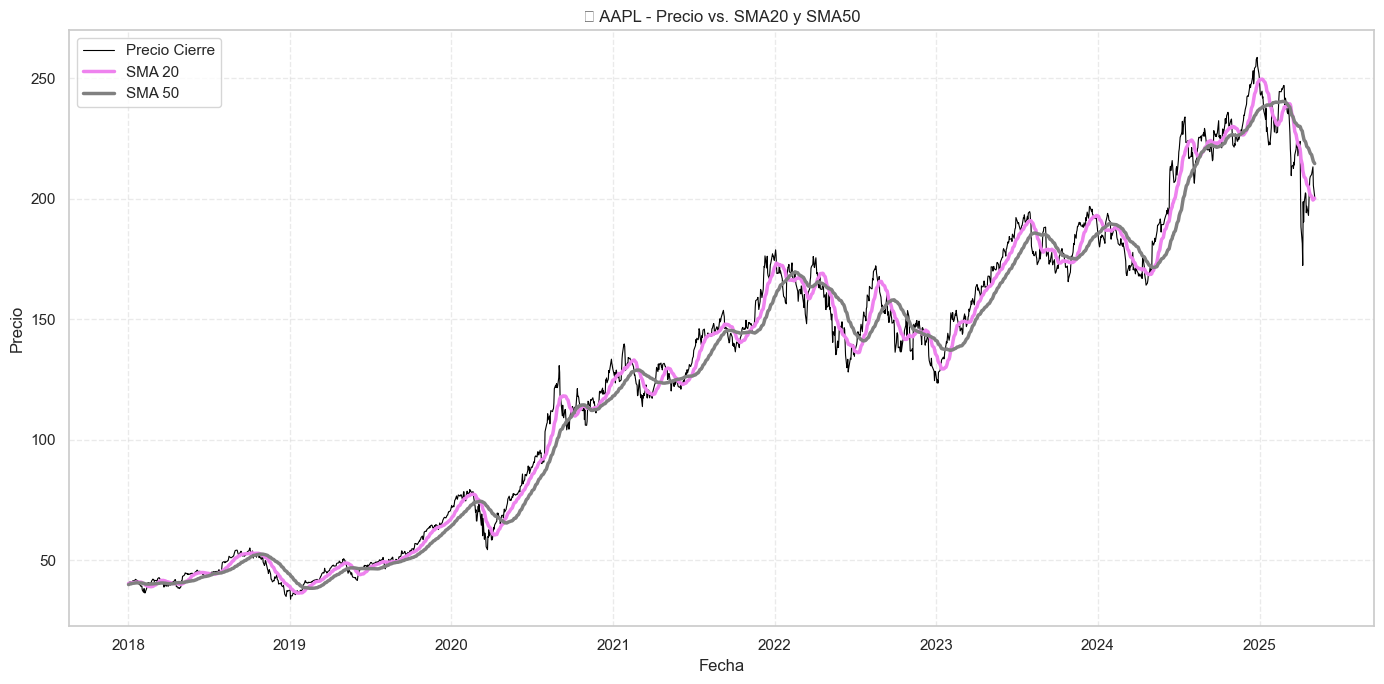

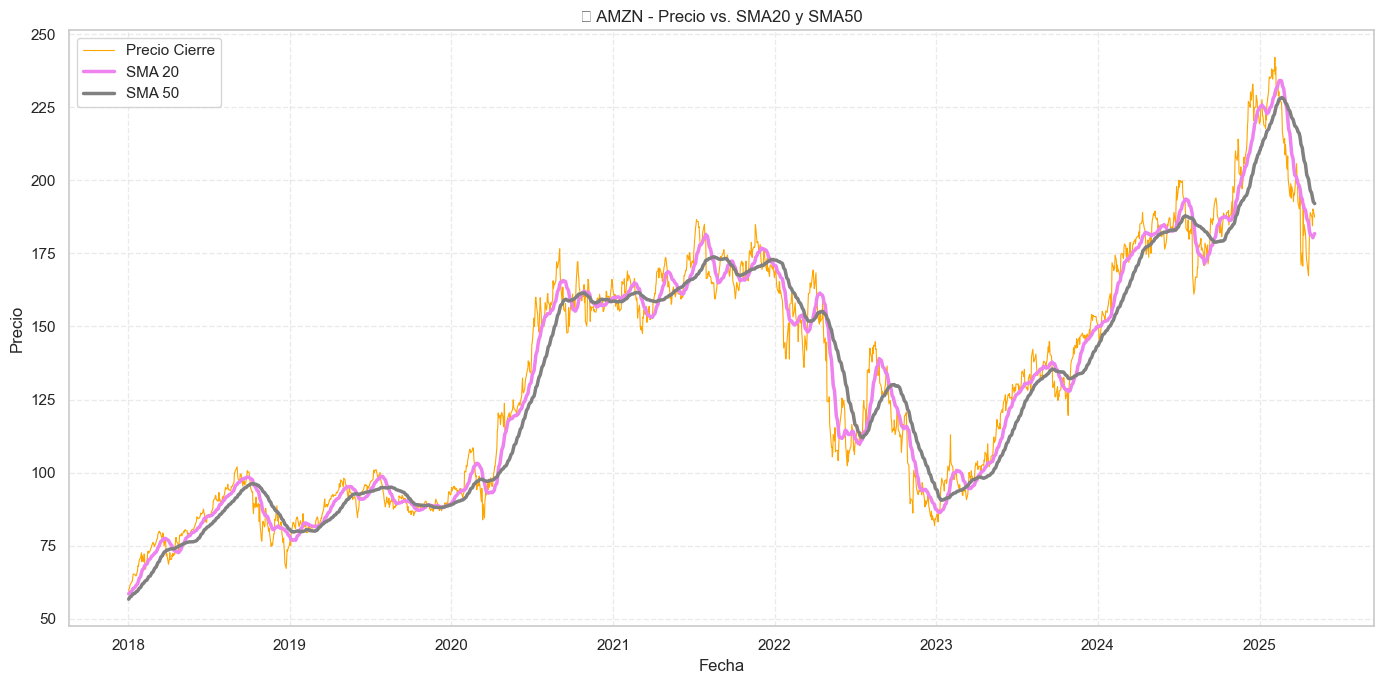

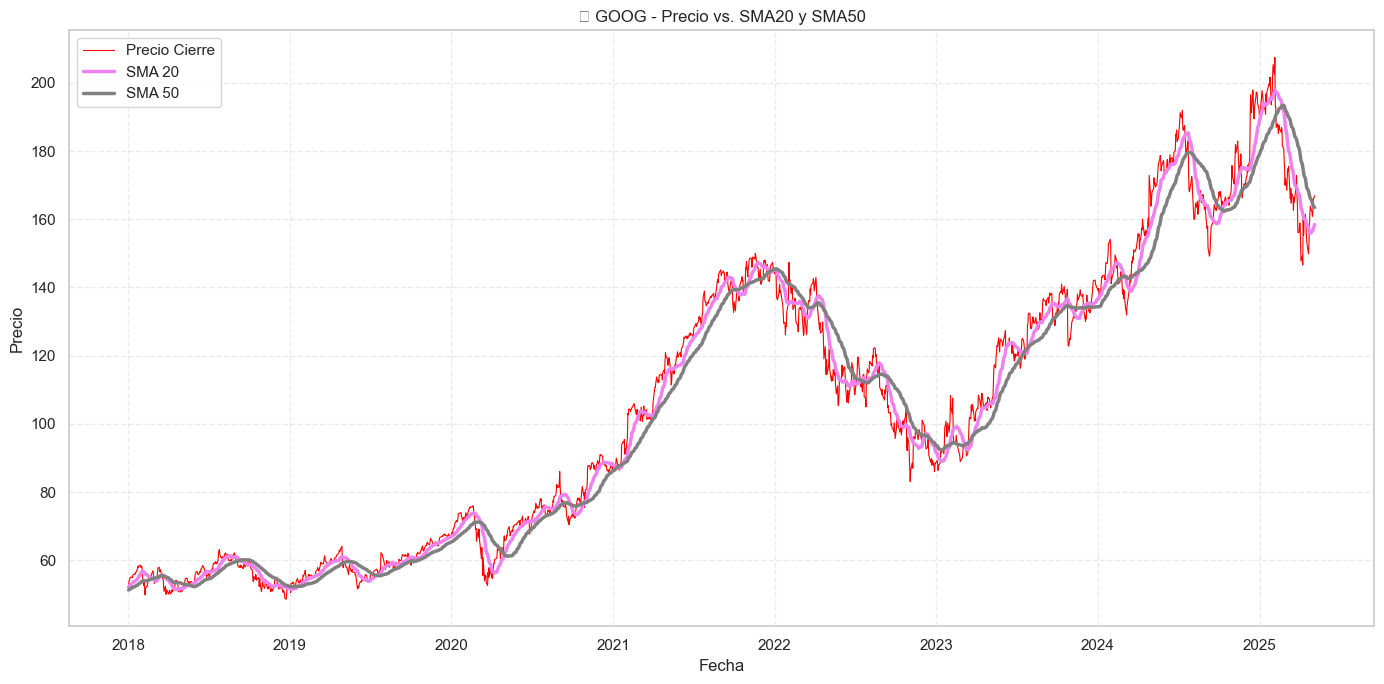

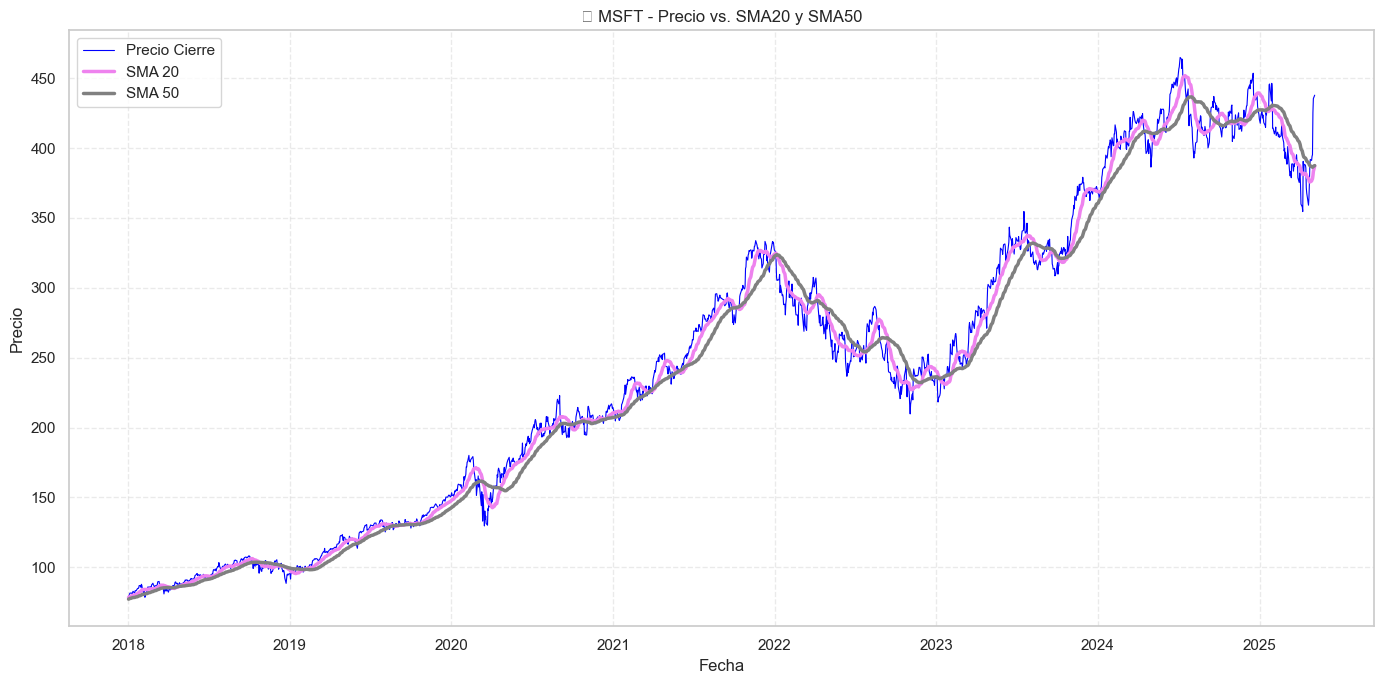

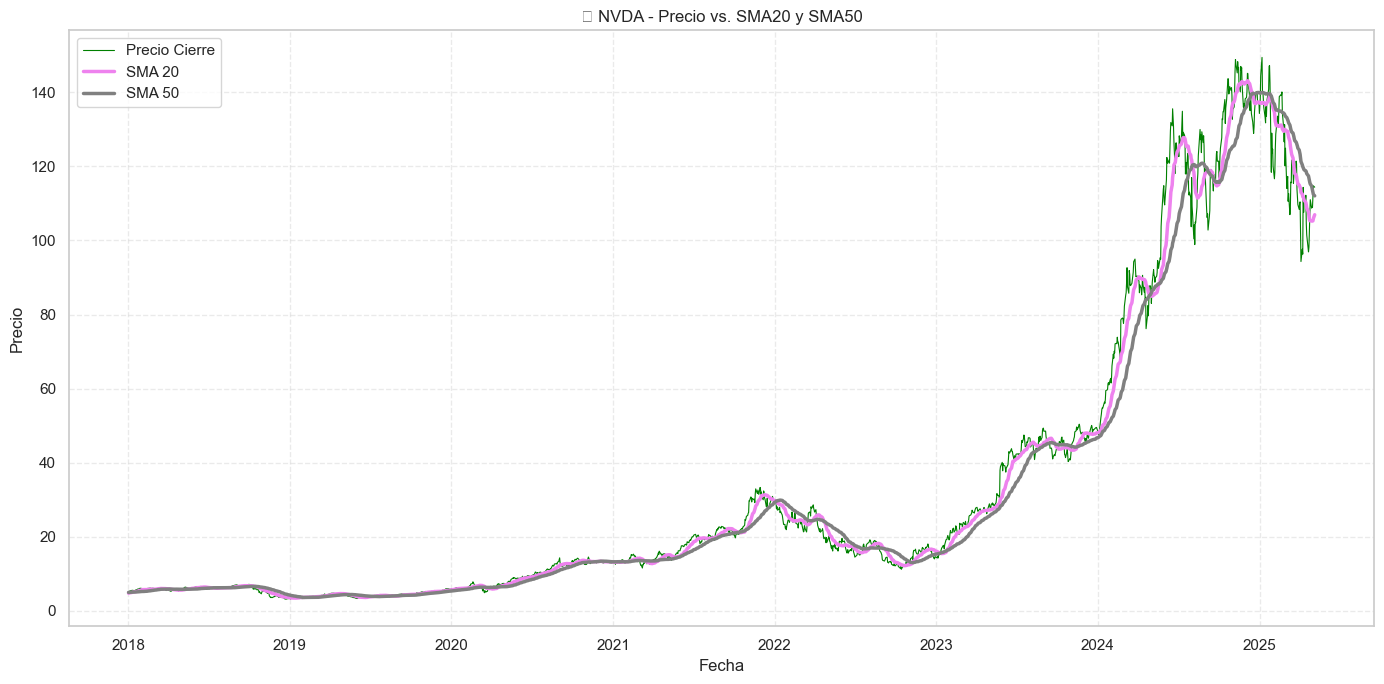

In [ ]:
def get_sma_y_precios_empresas_clave():
    import pandas as pd

    tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOG']
    placeholders = ','.join(['%s'] * len(tickers))

    query = f"""
    SELECT 
        it.date,
        it.ticker,
        ph.close,
        it.sma_20,
        it.sma_50
    FROM indicadores_tecnicos it
    JOIN precios_historicos ph ON it.ticker = ph.ticker AND it.date = ph.date
    WHERE it.ticker IN ({placeholders})
      AND it.sma_20 IS NOT NULL
      AND it.sma_50 IS NOT NULL
      AND ph.close IS NOT NULL
      and ph.date >= '2018-01-01'
    ORDER BY it.ticker, it.date
    """

    conn = get_connection()
    df = pd.read_sql_query(query, conn, params=tickers)
    conn.close()
    return df

# Ejecutar
sma_precios_df = get_sma_y_precios_empresas_clave()
sma_precios_df

# Asegurar formato de fecha
sma_precios_df['date'] = pd.to_datetime(sma_precios_df['date'])

# Colores personalizados por ticker
ticker_colores = {
    'MSFT': 'blue',
    'AAPL': 'black',
    'AMZN': 'orange',
    'GOOG': 'red',
    'NVDA': 'green'
}

# Graficar por acción
for ticker in sma_precios_df['ticker'].unique():
    df = sma_precios_df[sma_precios_df['ticker'] == ticker]

    plt.figure(figsize=(14, 7))
    plt.plot(df['date'], df['close'], label='Precio Cierre', color=ticker_colores[ticker], linewidth=0.8)
    plt.plot(df['date'], df['sma_20'], label='SMA 20', color='violet', linewidth=2.5) 
    plt.plot(df['date'], df['sma_50'], label='SMA 50', color='grey', linewidth=2.5)

    plt.title(f"📊 {ticker} - Precio vs. SMA20 y SMA50")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()





# 📊 Análisis de Cruces SMA20 vs. SMA50 en 5 Acciones Clave

### ⚫Apple (AAPL)

- **Tendencia**: Fuerte tendencia alcista desde 2019 hasta finales de 2021 y nuevo rally desde 2023.
- **Cruces**: Múltiples cruces dorados (SMA20 > SMA50) anticipan subas sostenidas.
- **Utilidad de SMA**: Muy útil para capturar cambios de tendencia, con señales limpias.

---

### 🟧 Amazon (AMZN)

- **Tendencia**: Volátil, con tramos alcistas hasta 2021, luego lateralidad con caídas parciales.
- **Cruces**: Cruces dorados a veces generaron falsas señales durante fases laterales.
- **Utilidad de SMA**: Eficaz en fases claras de tendencia, menos en consolidaciones.

---

### 🟥 Google (GOOG)

- **Tendencia**: Similar a AAPL, con rally fuerte post-2020 y correcciones suaves.
- **Cruces**: La SMA20 se adelanta bien a cambios de dirección; cruces confiables.
- **Utilidad de SMA**: Herramienta sólida para identificar puntos de entrada/salida.

---

### 🟦 Microsoft (MSFT)

- **Tendencia**: Fuerte crecimiento, leve desaceleración post-2022.
- **Cruces**: Claros cruces dorados y de muerte reflejan con precisión los ciclos.
- **Utilidad de SMA**: Muy confiable en este activo para seguir la tendencia.

---

### 🟩 NVIDIA (NVDA)

- **Tendencia**: Explosiva al alza desde 2023, tras consolidación prolongada.
- **Cruces**: Cruces dorados en 2023 preceden movimientos exponenciales.
- **Utilidad de SMA**: Altamente efectiva para capturar grandes impulsos.

---

## 🧠 Conclusión General

- La combinación **SMA20 y SMA50** es muy efectiva para detectar señales técnicas de cruce en activos con fuerte tendencia.
- En acciones muy volátiles (ej. AMZN), puede haber ruido que lleve a señales erróneas.
- Las señales de cruce son más confiables en entornos direccionales, especialmente con confirmación de volumen o tendencia del sector.



## 📅 03.06 Impacto de Eventos Macroeconómicos en Sectores Clave (2018-2025)

C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1106744979.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=sectores)
C:\Users\Agus\AppData\Local\Temp\ipykernel_8280\1106744979.py:75: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Agus\Desktop\PFM\Proyecto-Final-Hack-io-limpio\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


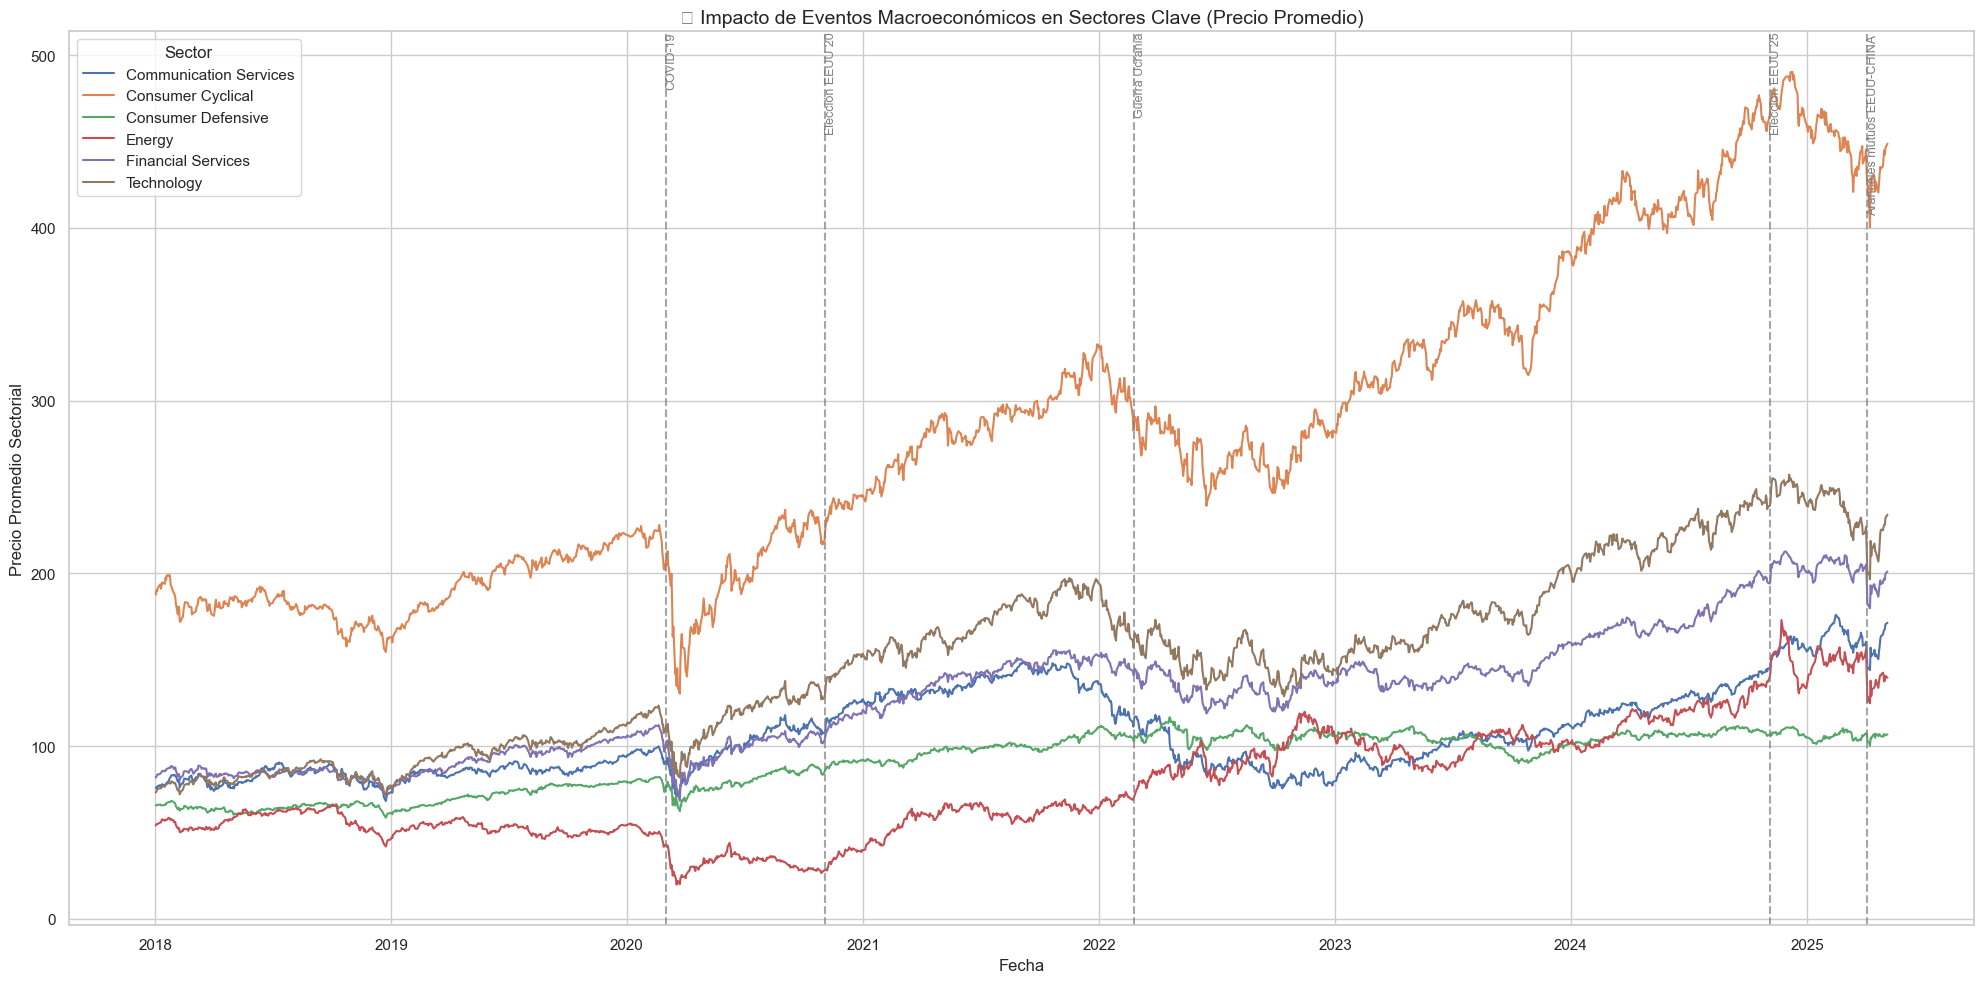

In [108]:
def get_precios_sectoriales():
    sectores = [
        'Technology',
        'Communication Services',
        'Consumer Cyclical',
        'Financial Services',
        'Consumer Defensive',
        'Energy'
    ]

    placeholders = ','.join(['%s'] * len(sectores))

    query = f"""
    SELECT 
        ph.date,
        e.sector,
        AVG(ph.close) AS precio_promedio
    FROM precios_historicos ph
    JOIN empresas e ON ph.ticker = e.ticker
    WHERE e.sector IN ({placeholders})
      AND ph.close IS NOT NULL
      and ph.date >= '2018-01-01'
    GROUP BY ph.date, e.sector
    ORDER BY ph.date
    """

    conn = get_connection()
    df = pd.read_sql_query(query, conn, params=sectores)
    conn.close()
    return df

# Ejecutar
precios_sector_df = get_precios_sectoriales()
precios_sector_df


# Suponiendo que precios_sector_df ya fue obtenido con la query del usuario:
# Simulación mínima para evitar errores durante la ejecución
# En ejecución real: precios_sector_df = get_precios_sectoriales()

# Asegurar que las fechas están en datetime
precios_sector_df['date'] = pd.to_datetime(precios_sector_df['date'])

# Eventos a marcar
eventos = {

    'COVID-19': '2020-03-01',
    'Elección EEUU 20': '2020-11-03',
    'Guerra Ucrania': '2022-02-24',
    'Elección EEUU 25': '2024-11-05',
    'Aranceles mutuos EEUU-CHINA ': '2025-04-04',

}

# Graficar
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))

for sector in precios_sector_df['sector'].unique():
    df_sector = precios_sector_df[precios_sector_df['sector'] == sector]
    plt.plot(df_sector['date'], df_sector['precio_promedio'], label=sector)

# Líneas de eventos
for nombre, fecha in eventos.items():
    fecha_evento = pd.to_datetime(fecha)
    plt.axvline(fecha_evento, color='gray', linestyle='--', alpha=0.7)
    plt.text(fecha_evento, plt.ylim()[1], nombre, rotation=90,
             verticalalignment='top', fontsize=9, color='gray')

# Estética
plt.title('📅 Impacto de Eventos Macroeconómicos en Sectores Clave (Precio Promedio)', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio Sectorial')
plt.legend(title='Sector')
plt.tight_layout()
plt.show()

## 📅 Impacto de Eventos Macroeconómicos en Sectores Clave (2018-2025)

Este gráfico examina cómo reaccionaron los principales sectores bursátiles ante eventos macroeconómicos recientes. A continuación, se detalla el impacto observado **por evento**.

---

### 🦠 COVID-19 (Marzo 2020)

**Fecha clave:** 2020-03-01  
**Contexto:** Inicio de la pandemia global, colapso económico temporal, cuarentenas masivas.

#### Comportamiento por sector:
- **Todos los sectores** cayeron abruptamente, especialmente en marzo.
- **Technology** cayó, pero mostró **una de las recuperaciones más rápidas y fuertes**, impulsada por la digitalización y trabajo remoto.
- **Consumer Cyclical** también repuntó rápidamente gracias al estímulo fiscal y consumo post-pandemia.
- **Energy** se hundió severamente por la caída de demanda global; la recuperación fue más lenta.
- **Financial Services** bajó por incertidumbre crediticia y tasas en mínimos históricos.
- **Consumer Defensive** mostró **menor caída** inicial, actuando como refugio defensivo.

✅ **Conclusión:** El shock inicial fue fuerte, pero los sectores ofensivos recuperaron más rápido por digitalización y estímulo monetario.

---

### 🗳️ Elección Presidencial EEUU 2020 (Noviembre 2020)

**Fecha clave:** 2020-11-03  
**Contexto:** Victoria de Biden, expectativas de estímulo, política fiscal expansiva.

#### Comportamiento por sector:
- **Technology** y **Communication Services** mantuvieron su tendencia alcista, descontando políticas pro-inversión e infraestructura digital.
- **Financial Services** comenzó a recuperarse, anticipando tasas más altas y control fiscal.
- **Energy** siguió con bajo desempeño, afectado por regulaciones ambientales proyectadas.
- **Consumer Defensive** mantuvo estabilidad sin cambios relevantes.

✅ **Conclusión:** Los sectores de crecimiento extendieron su rally; los cíclicos comenzaron a mejorar por expectativas de inversión pública.

---

### ⚔️ Guerra en Ucrania (Febrero 2022)

**Fecha clave:** 2022-02-24  
**Contexto:** Invasión rusa, disrupción energética, tensiones geopolíticas.

#### Comportamiento por sector:
- **Energy** experimentó un **salto inmediato en precios**, impulsado por la crisis energética global.
- **Technology** y **Communication Services** se vieron más afectados, cayendo por aversión al riesgo y suba de tasas.
- **Financial Services** fue volátil, reflejando incertidumbre macro y tensiones en el sistema financiero global.
- **Consumer Defensive** mostró una buena defensa ante el entorno incierto.

✅ **Conclusión:** Beneficio directo para energía, castigo para sectores sensibles a tasas y estabilidad.

---

### 🗳️ Elección Presidencial EEUU 2024 (Proyección - Noviembre 2024)

**Fecha clave:** 2024-11-05  
**Contexto proyectado:** Cambio o continuidad política, impacto potencial en regulación e impuestos.

#### Comportamiento anticipado:
- **Volatilidad anticipada** en todos los sectores, sin dirección clara aún.
- **Technology** y **Financial Services** podrían reaccionar según expectativas sobre regulación, impuestos corporativos y tasas.

✅ **Conclusión (provisional):** El mercado se posiciona cautelosamente, con sensibilidad a la política económica futura.

---

### 💼 Tensiones Comerciales EE.UU.–China (Abril 2025)

**Fecha clave:** 2025-04-04  
**Contexto:** Escalada de aranceles mutuos, mayor fricción entre potencias, impacto en el comercio internacional y cadenas de suministro.

#### Comportamiento observado:

- **Technology** mostró una **fuerte corrección inmediata**, reflejando preocupaciones sobre la cadena de semiconductores, exportaciones y presión sobre valuaciones.
- **Consumer Cyclical** también **cayó bruscamente**, sensible a aranceles y aumento en costos de importación.
- **Energy** tuvo una **caída significativa**, posiblemente por temores de menor demanda global ante fricción económica.
- **Financial Services** **retrocedió de forma moderada a fuerte**, en línea con mayor incertidumbre macroeconómica y potencial impacto en flujos comerciales.
- **Communication Services** experimentó una **baja clara**, aunque algo más moderada que tecnología.
- **Consumer Defensive** fue el único que se mantuvo relativamente más estable, actuando como refugio defensivo.

✅ **Conclusión:** El evento generó un impacto negativo inmediato y generalizado, con **caídas abruptas en sectores expuestos al comercio global y la tecnología**. La magnitud de la corrección sugiere **alta sensibilidad sistémica** a este tipo de eventos geopolíticos prolongados.


---



